## Compare GWTC-3 Gaussian Spin Model results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
from tqdm.notebook import tqdm
from scipy.stats import gaussian_kde
import sys
sys.path.append('../code/')
sys.path.append('./')
import os
from support import *
from makeCorner import *
import h5py,json

plot_green = '#50A06E'
plot_blue = '#2A42A6'
plot_red = '#A72A43'
plot_purple = '#8E2AA7'

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

processed_samps_A = np.load('../results/processed_AllSamples_r00.npy','r')
processed_samps_K = np.load('../results/processed_Analytical_result_r00.npy','r')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import os
os.listdir('../results/')

['AllSamples_r00.npy',
 '.DS_Store',
 'KDE_result_r00.npy',
 'OG_prior',
 'processed_AllSamples_r00.npy',
 'Analytical_result_r00.npy',
 'processed_KDE_result_r00.npy',
 'processed_Analytical_result_r00.npy']

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import gaussian_filter
def plot_corner_overlay(fig,plot_datas,colors,labels,hist_alpha=1,bins=20,labelsize=14,kernel=2,fill=False):
    
    # Input variable plot_data should be a dictionary whose keys are the individual variables to plot.
    # Each key should, in turn, link to another nested dictionary with the following keys:
    # - "data" : Actual data values
    # - "plot_bounds" : Tuple of min/max values to display on plot
    # - "label" : Latex string for figure labeling
    
    # Loop across dimensions that we want to plot
    keys = list(plot_datas[0])    
    ndim = len(keys)
    lines = []
    
    for i, key in enumerate(keys):
        # Plot the marginal 1D posterior (i.e. top of a corner plot column)
        ax = fig.add_subplot(ndim, ndim, int(1+(ndim+1)*i))
        ax.tick_params(left=False, labelleft=False)
        
        for j, plot_data in enumerate(plot_datas):
            hist, _, _ = ax.hist(plot_data[key]['data'], bins=np.linspace(plot_data[key]['plot_bounds'][0], plot_data[key]['plot_bounds'][1], bins),
                color=colors[j], alpha=hist_alpha, histtype='step', density=True, zorder=0)
            if i == 0:
                lines.append(plt.Rectangle((0,0), 1, 1, fc=colors[j], ec="none"))  # ダミーの長方形を作成
        ax.set_xlim(plot_data[key]['plot_bounds'][0], plot_data[key]['plot_bounds'][1])

        # If this is the last dimension add an x-axis label
        if i==ndim-1:
            ax.set_xlabel(plot_data[key]['label'],fontsize=labelsize)
            
        # If not the last dimension, loop across other variables and fill in the rest of the column with 2D plots
        else:
            
            ax.set_xticklabels([])
            for j,k in enumerate(keys[i+1:]):
                
                # Make a 2D density plot
                ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))
                
                #for l,plot_data in enumerate(plot_datas):
                #    # Define a linear color map
                #    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",colors[l]])
                #    ax.hexbin(plot_data[key]['data'],plot_data[k]['data'],cmap=cmap,mincnt=1,gridsize=bins,\
                #         extent=(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],plot_data[k]['plot_bounds'][0],plot_data[k]['plot_bounds'][1]),
                #         linewidths=(0,),zorder=0)
                
                xgrid = np.linspace(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],100)
                ygrid = np.linspace(plot_data[k]['plot_bounds'][0],plot_data[k]['plot_bounds'][1],100)
                dx = xgrid[1]-xgrid[0]
                dy = ygrid[1]-ygrid[0]

                for l,plot_data in enumerate(plot_datas):                    
                    heights,edgex,edgey = np.histogram2d(plot_data[key]['data'],plot_data[k]['data'],
                                                     bins=(xgrid,ygrid))
                    heights = gaussian_filter(heights,kernel)
                    heights /= np.sum(heights)*dx*dy
                    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
                    cdf = np.cumsum(heights_large_to_small)*dx*dy
                    
                    h50 = np.interp(0.5,cdf,heights_large_to_small)
                    h90 = np.interp(0.9,cdf,heights_large_to_small)
                    h99 = np.interp(0.99,cdf,heights_large_to_small)
                    #ax.contour((xgrid[:-1]+xgrid[1:])/2,(ygrid[:-1]+ygrid[1:])/2,heights.T,levels=(h90,h50,np.inf),colors=colors[l],linewidths=[0.275,0.55,1.1,0])
                    ax.contour((xgrid[:-1]+xgrid[1:])/2,(ygrid[:-1]+ygrid[1:])/2,heights.T,levels=(h90,h50,np.inf),colors=colors[l],linewidths=[1.1,1.1,0])
                    if fill:
                        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",colors[l]])
                        ax.contourf((xgrid[:-1]+xgrid[1:])/2,(ygrid[:-1]+ygrid[1:])/2,heights.T,levels=(h90,h50,np.max(heights)),cmap=cmap,alpha = hist_alpha/2)
                    
                    #cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",colors[l]])
                    #ax.hexbin(plot_data[key]['data'],plot_data[k]['data'],cmap=cmap,mincnt=1,gridsize=bins,\
                    #     extent=(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],plot_data[k]['plot_bounds'][0],plot_data[k]['plot_bounds'][1]),
                    #     linewidths=(0,),zorder=0)
                    #ax.contourf((xgrid[:-1]+xgrid[1:])/2,(ygrid[:-1]+ygrid[1:])/2,heights.T,levels=(h90,h50,np.max(heights)),alpha=1, cmap=cmap)
                    
                
                # Set plot bounds
                ax.set_xlim(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1])
                ax.set_ylim(plot_data[k]['plot_bounds'][0],plot_data[k]['plot_bounds'][1])
                ax.grid(True,dashes=(1,3))
                
                # If still in the first column, add a y-axis label
                if i==0:
                    ax.set_ylabel(plot_data[k]['label'],fontsize=labelsize)
                else:
                    ax.set_yticklabels([])
               
                # If on the last row, add an x-axis label
                if j==ndim-i-2:
                    ax.set_xlabel(plot_data[key]['label'],fontsize=labelsize)
                else:
                    ax.set_xticklabels([])
                    
    # 図全体のレジェンドを作成
    fig.legend(handles = lines, labels=labels, loc='upper right', bbox_to_anchor=(0.99, 0.99), fontsize=labelsize)

    plt.tight_layout()
    # レジェンドのためのスペースを確保
    plt.subplots_adjust(right=0.85)
    return fig  

#Full plot
to_plots = []
for processed_samps in [processed_samps_K,processed_samps_A]:
    to_plot = {
    'alpha':{'data':processed_samps[:,0],'plot_bounds':(-5.5,-2),'label':r"$\alpha$"},
    'mMax':{'data':processed_samps[:,1],'plot_bounds':(60,100),'label':r"$M_\mathrm{max}$"},
    'm0':{'data':processed_samps[:,2],'plot_bounds':(20,40),'label':r"$\mu_m$"},
    'sigM':{'data':processed_samps[:,3],'plot_bounds':(1,10),'label':r"$\sigma_m$"},
    'fPeak':{'data':processed_samps[:,4],'plot_bounds':(0,.2),'label':r"$f_\mathrm{peak}$"},
    'bq':{'data':processed_samps[:,5],'plot_bounds':(-2,10),'label':r"$\beta_q$"},
    'kappa':{'data':processed_samps[:,6],'plot_bounds':(-2,8),'label':r"$\kappa$"},
    'muEff':{'data':processed_samps[:,-5],'plot_bounds':(-0.05,0.15),'label':r"$\mu_\mathrm{eff}$"},
    'sigEff':{'data':processed_samps[:,-4],'plot_bounds':(0,0.2),'label':r"$\sigma_\mathrm{eff}$"},
    'muP':{'data':processed_samps[:,-3],'plot_bounds':(0.05,0.5),'label':r"$\mu_\mathrm{p}$"},
    'sigP':{'data':processed_samps[:,-2],'plot_bounds':(0.05,0.6),'label':r"$\sigma_\mathrm{p}$"},
    'rho':{'data':processed_samps[:,-1],'plot_bounds':(-0.8,0.8),'label':r"$\rho$"}
    }
    to_plots.append(to_plot)

fig = plt.figure(figsize=(14,14))
plot_colors = [plot_blue,plot_green]
plot_corner_overlay(fig,to_plots,plot_colors,labels=['KDE prior','Analytical prior'],bins=25)
plt.tight_layout()
#fig.savefig('Corner_Full.pdf',bbox_inches='tight')
plt.show()

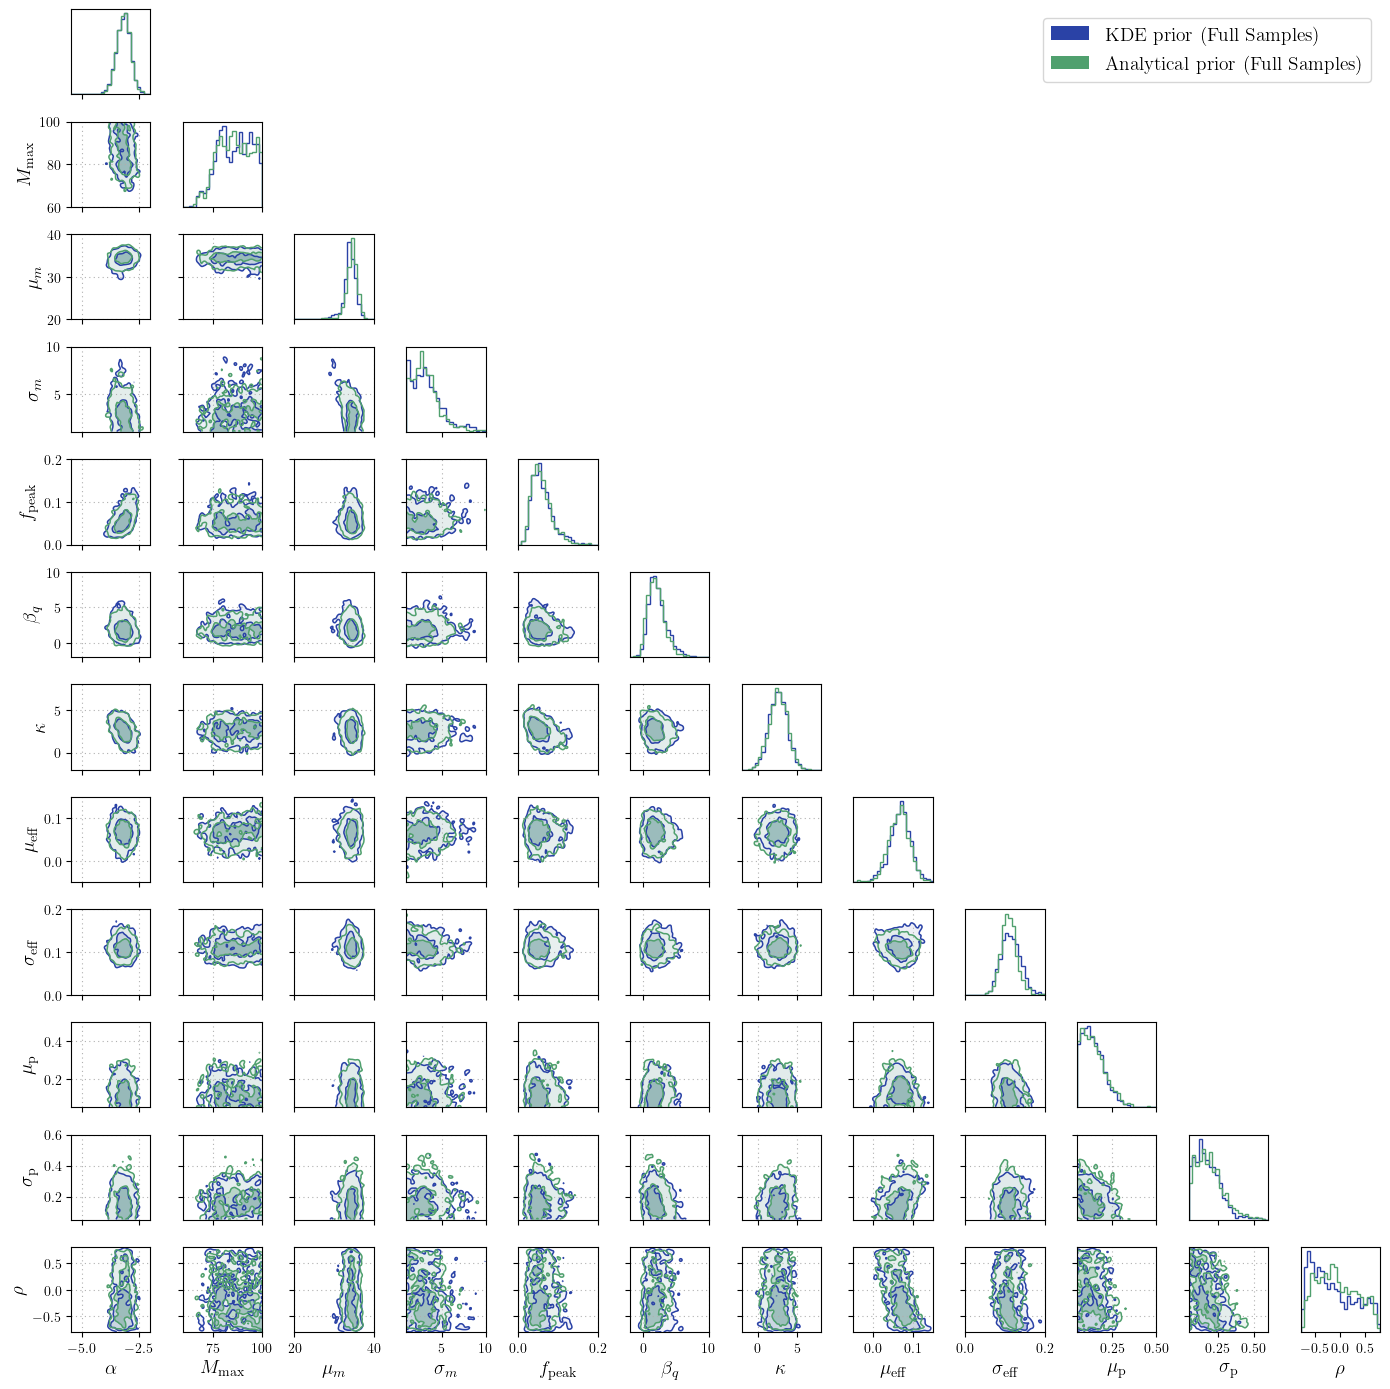

In [4]:
#Full plot
to_plots = []
for processed_samps in [processed_samps_K,processed_samps_A]:
    to_plot = {
    'alpha':{'data':processed_samps[:,0],'plot_bounds':(-5.5,-2),'label':r"$\alpha$"},
    'mMax':{'data':processed_samps[:,1],'plot_bounds':(60,100),'label':r"$M_\mathrm{max}$"},
    'm0':{'data':processed_samps[:,2],'plot_bounds':(20,40),'label':r"$\mu_m$"},
    'sigM':{'data':processed_samps[:,3],'plot_bounds':(1,10),'label':r"$\sigma_m$"},
    'fPeak':{'data':processed_samps[:,4],'plot_bounds':(0,.2),'label':r"$f_\mathrm{peak}$"},
    'bq':{'data':processed_samps[:,5],'plot_bounds':(-2,10),'label':r"$\beta_q$"},
    'kappa':{'data':processed_samps[:,6],'plot_bounds':(-2,8),'label':r"$\kappa$"},
    'muEff':{'data':processed_samps[:,-5],'plot_bounds':(-0.05,0.15),'label':r"$\mu_\mathrm{eff}$"},
    'sigEff':{'data':processed_samps[:,-4],'plot_bounds':(0,0.2),'label':r"$\sigma_\mathrm{eff}$"},
    'muP':{'data':processed_samps[:,-3],'plot_bounds':(0.05,0.5),'label':r"$\mu_\mathrm{p}$"},
    'sigP':{'data':processed_samps[:,-2],'plot_bounds':(0.05,0.6),'label':r"$\sigma_\mathrm{p}$"},
    'rho':{'data':processed_samps[:,-1],'plot_bounds':(-0.8,0.8),'label':r"$\rho$"}
    }
    to_plots.append(to_plot)

fig = plt.figure(figsize=(14,14))
plot_colors = [plot_blue,plot_green]
labels=["KDE prior (Full Samples)",'Analytical prior (Full Samples)']
plot_corner_overlay(fig,to_plots,plot_colors,labels=labels,bins=25,fill = True)
plt.tight_layout()
fig.savefig('Corner_Full.pdf',bbox_inches='tight')
plt.show()

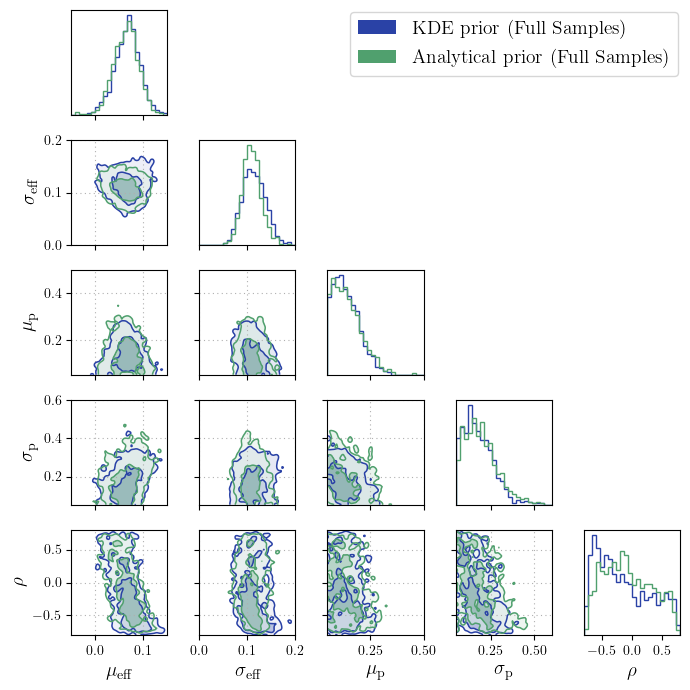

In [5]:
#Full plot
to_plots = []
for processed_samps in [processed_samps_K,processed_samps_A]:
    to_plot = {
    'muEff':{'data':processed_samps[:,-5],'plot_bounds':(-0.05,0.15),'label':r"$\mu_\mathrm{eff}$"},
    'sigEff':{'data':processed_samps[:,-4],'plot_bounds':(0,0.2),'label':r"$\sigma_\mathrm{eff}$"},
    'muP':{'data':processed_samps[:,-3],'plot_bounds':(0.05,0.5),'label':r"$\mu_\mathrm{p}$"},
    'sigP':{'data':processed_samps[:,-2],'plot_bounds':(0.05,0.6),'label':r"$\sigma_\mathrm{p}$"},
    'rho':{'data':processed_samps[:,-1],'plot_bounds':(-0.8,0.8),'label':r"$\rho$"}
    }
    to_plots.append(to_plot)

fig = plt.figure(figsize=(7,7))
plot_colors = [plot_blue,plot_green]
plot_corner_overlay(fig,to_plots,plot_colors,labels=labels,bins=25,fill = True)
plt.tight_layout()
fig.savefig('Corner_Spins.pdf',bbox_inches='tight')
plt.show()

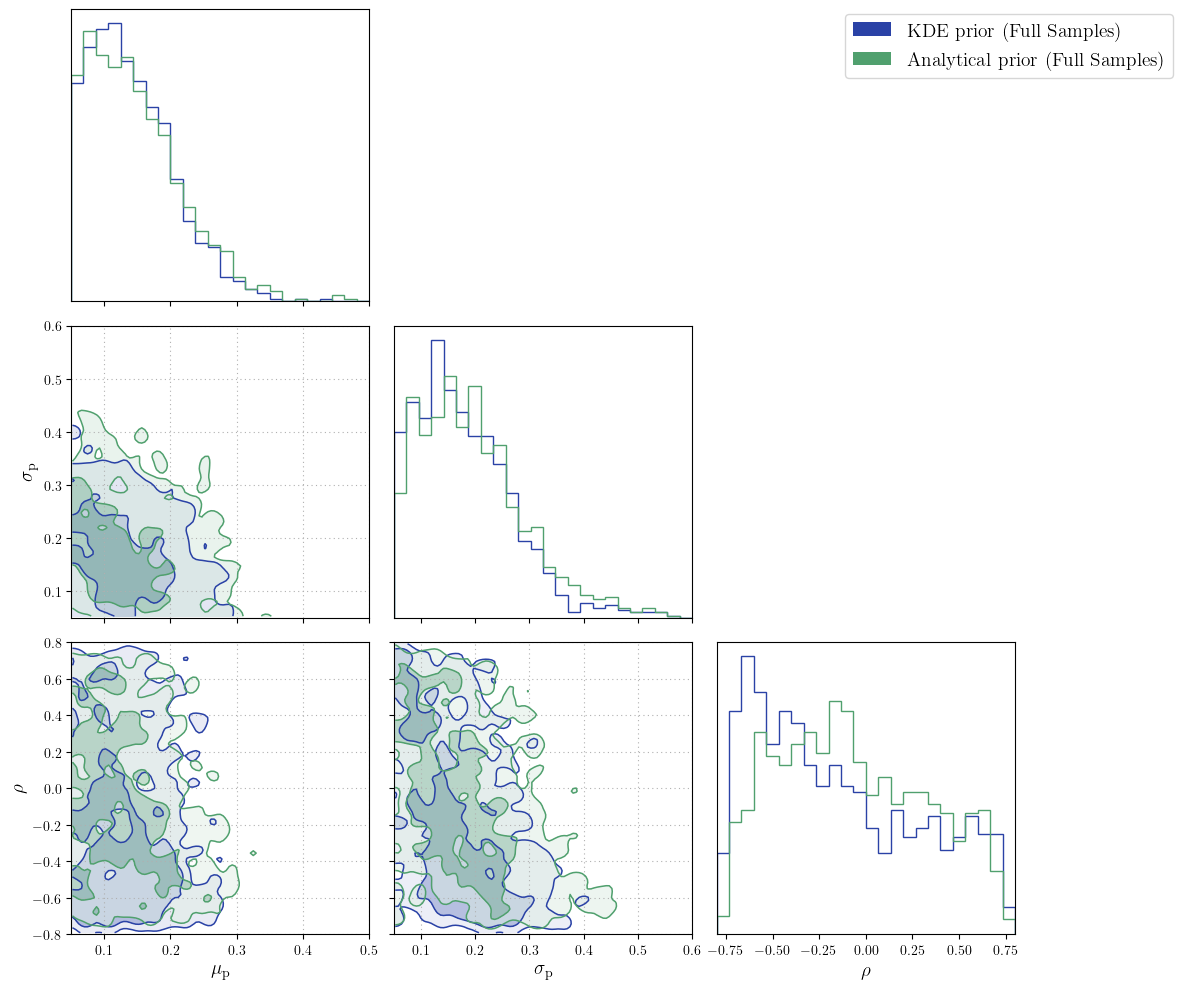

In [6]:
#Xp related parameter only

fig = plt.figure(figsize=(12,10))
plot_colors = [plot_blue,plot_green]
to_plots = []
for processed_samps in [processed_samps_K,processed_samps_A]:
    to_plot = {
    'muP':{'data':processed_samps[:,-3],'plot_bounds':(0.05,0.5),'label':r"$\mu_\mathrm{p}$"},
    'sigP':{'data':processed_samps[:,-2],'plot_bounds':(0.05,0.6),'label':r"$\sigma_\mathrm{p}$"},
    'rho':{'data':processed_samps[:,-1],'plot_bounds':(-0.8,0.8),'label':r"$\rho$"}
    }
    to_plots.append(to_plot)
plot_corner_overlay(fig,to_plots,plot_colors,labels=labels,bins=25,fill=True)
fig.savefig('Corner_Xp_related.pdf',bbox_inches='tight')
plt.show()

KDE prior (Downsampled)
Gaussian mean = 0.14 +0.14 -0.08
Gaussian SD = 0.18 +0.15 -0.11

0.16
KDE prior (Full Samples)
Gaussian mean = 0.13 +0.13 -0.07
Gaussian SD = 0.17 +0.19 -0.10

0.159
Analytical prior (Full Samples)
Gaussian mean = 0.14 +0.14 -0.08
Gaussian SD = 0.18 +0.21 -0.11

0.16


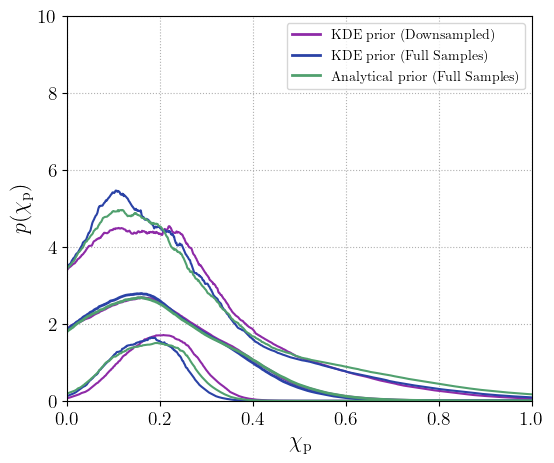

In [55]:
fig,ax = plt.subplots(figsize=(6,5))
x_grid = np.linspace(0,1,1001)
labels=["KDE prior (Downsampled)","KDE prior (Full Samples)",'Analytical prior (Full Samples)']
plot_colors = [plot_purple,plot_blue,plot_green]
processed_samps_K0 = np.load('../../o3b-pop-studies-rerun/results/OG_prior/processed_gaussian_spin_samples_FAR_1_in_1_r00.npy','r')

for j,processed_samps in enumerate([processed_samps_K0,processed_samps_K,processed_samps_A]):
    mu = processed_samps[:,-3]
    sig = processed_samps[:,-2]
    print(labels[j])
    print('Gaussian mean = {:.2f} +{:.2f} -{:.2f}'.format(np.median(mu),np.quantile(mu,0.95)-np.median(mu),np.median(mu)-np.quantile(mu,0.05)))
    print('Gaussian SD = {:.2f} +{:.2f} -{:.2f}'.format(np.median(sig),np.quantile(sig,0.95)-np.median(sig),np.median(sig)-np.quantile(sig,0.05)))
    print('')
    ys = np.zeros((mu.size,x_grid.size))
    for i in range(mu.size):
        y = calculate_Gaussian(x_grid,mu[i],sig[i]**2.,0,1)
        #ax.plot(x_grid,y,color=plot_color,alpha=0.2,lw=0.2)
        ys[i,:] = y
    
    ax.plot(x_grid,np.quantile(ys,0.05,axis=0),color=plot_colors[j])
    ax.plot(x_grid,np.quantile(ys,0.50,axis=0),color=plot_colors[j],linewidth=2,label=labels[j])
    ax.plot(x_grid,np.quantile(ys,0.95,axis=0),color=plot_colors[j])
    
    print(x_grid[np.argmax(np.quantile(ys,0.5,axis=0))])
    
#ax.legend(loc='upper right',frameon=False)
ax.legend(loc='upper right')
ax.set_xlim(0,1)
ax.set_ylim(0,10)
ax.axes.grid(True,which='major',ls=':')
ax.set_xlabel(r'$\chi_\mathrm{p}$',fontsize=16)
ax.set_ylabel(r'$p(\chi_\mathrm{p})$',fontsize=16)
ax.tick_params(labelsize=14)
plt.savefig('PPD_Xp.pdf')

Analytical prior (Full Samples)
Gaussian mean = 0.14 +0.14 -0.08
Gaussian SD = 0.18 +0.21 -0.11

0.16


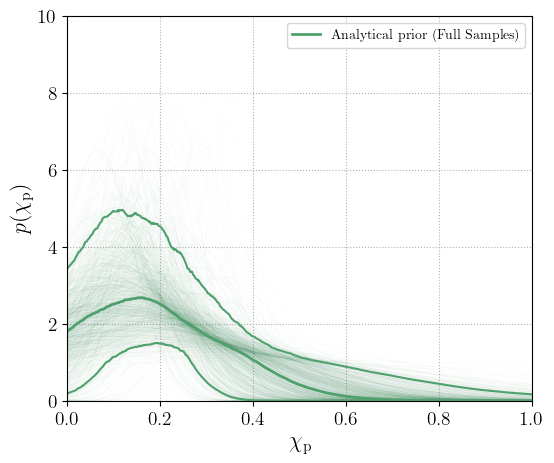

In [9]:
fig,ax = plt.subplots(figsize=(6,5))
x_grid = np.linspace(0,1,1001)
labels=['Analytical prior (Full Samples)']
plot_colors = [plot_green]
processed_samps_K0 = np.load('../../o3b-pop-studies-rerun/results/OG_prior/processed_gaussian_spin_samples_FAR_1_in_1_r00.npy','r')

for j,processed_samps in enumerate([processed_samps_A]):
    mu = processed_samps[:,-3]
    sig = processed_samps[:,-2]
    print(labels[j])
    print('Gaussian mean = {:.2f} +{:.2f} -{:.2f}'.format(np.median(mu),np.quantile(mu,0.95)-np.median(mu),np.median(mu)-np.quantile(mu,0.05)))
    print('Gaussian SD = {:.2f} +{:.2f} -{:.2f}'.format(np.median(sig),np.quantile(sig,0.95)-np.median(sig),np.median(sig)-np.quantile(sig,0.05)))
    print('')
    ys = np.zeros((mu.size,x_grid.size))
    for i in range(mu.size):
        y = calculate_Gaussian(x_grid,mu[i],sig[i]**2.,0,1)
        ax.plot(x_grid,y,color=plot_colors[j],alpha=2/np.sqrt(mu.size),lw=0.2)
        ys[i,:] = y
    
    ax.plot(x_grid,np.quantile(ys,0.05,axis=0),color=plot_colors[j])
    ax.plot(x_grid,np.quantile(ys,0.50,axis=0),color=plot_colors[j],linewidth=2,label=labels[j])
    ax.plot(x_grid,np.quantile(ys,0.95,axis=0),color=plot_colors[j])
    
    print(x_grid[np.argmax(np.quantile(ys,0.5,axis=0))])
    
#ax.legend(loc='upper right',frameon=False)
ax.legend(loc='upper right')
ax.set_xlim(0,1)
ax.set_ylim(0,10)
ax.axes.grid(True,which='major',ls=':')
ax.set_xlabel(r'$\chi_\mathrm{p}$',fontsize=16)
ax.set_ylabel(r'$p(\chi_\mathrm{p})$',fontsize=16)
ax.tick_params(labelsize=14)
#plt.savefig('PPD_Xp.pdf')

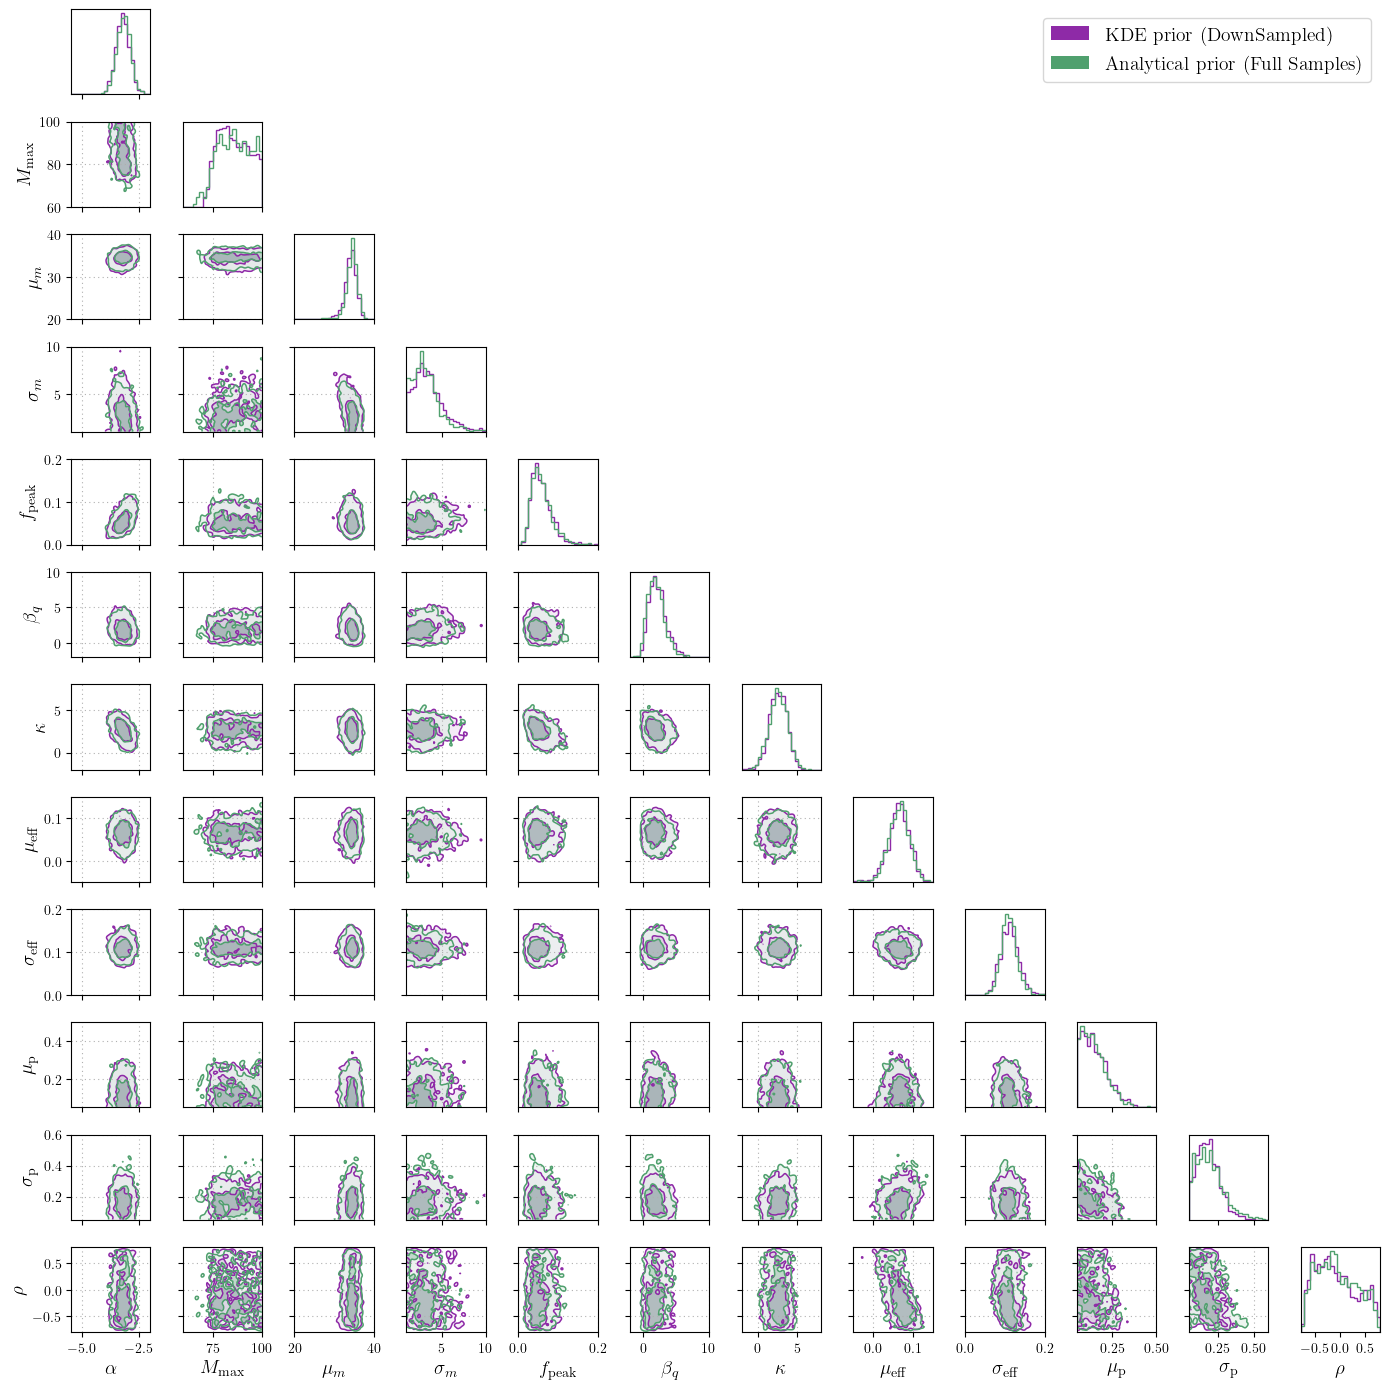

In [56]:
#Full plot
to_plots = []
for processed_samps in [processed_samps_K0,processed_samps_A]:
    to_plot = {
    'alpha':{'data':processed_samps[:,0],'plot_bounds':(-5.5,-2),'label':r"$\alpha$"},
    'mMax':{'data':processed_samps[:,1],'plot_bounds':(60,100),'label':r"$M_\mathrm{max}$"},
    'm0':{'data':processed_samps[:,2],'plot_bounds':(20,40),'label':r"$\mu_m$"},
    'sigM':{'data':processed_samps[:,3],'plot_bounds':(1,10),'label':r"$\sigma_m$"},
    'fPeak':{'data':processed_samps[:,4],'plot_bounds':(0,.2),'label':r"$f_\mathrm{peak}$"},
    'bq':{'data':processed_samps[:,5],'plot_bounds':(-2,10),'label':r"$\beta_q$"},
    'kappa':{'data':processed_samps[:,6],'plot_bounds':(-2,8),'label':r"$\kappa$"},
    'muEff':{'data':processed_samps[:,-5],'plot_bounds':(-0.05,0.15),'label':r"$\mu_\mathrm{eff}$"},
    'sigEff':{'data':processed_samps[:,-4],'plot_bounds':(0,0.2),'label':r"$\sigma_\mathrm{eff}$"},
    'muP':{'data':processed_samps[:,-3],'plot_bounds':(0.05,0.5),'label':r"$\mu_\mathrm{p}$"},
    'sigP':{'data':processed_samps[:,-2],'plot_bounds':(0.05,0.6),'label':r"$\sigma_\mathrm{p}$"},
    'rho':{'data':processed_samps[:,-1],'plot_bounds':(-0.8,0.8),'label':r"$\rho$"}
    }
    to_plots.append(to_plot)

fig = plt.figure(figsize=(14,14))
plot_colors = [plot_purple,plot_green]
labels=["KDE prior (DownSampled)",'Analytical prior (Full Samples)']
plot_corner_overlay(fig,to_plots,plot_colors,labels=labels,bins=25,fill = True)
plt.tight_layout()
#fig.savefig('Corner_Full.pdf',bbox_inches='tight')
plt.show()

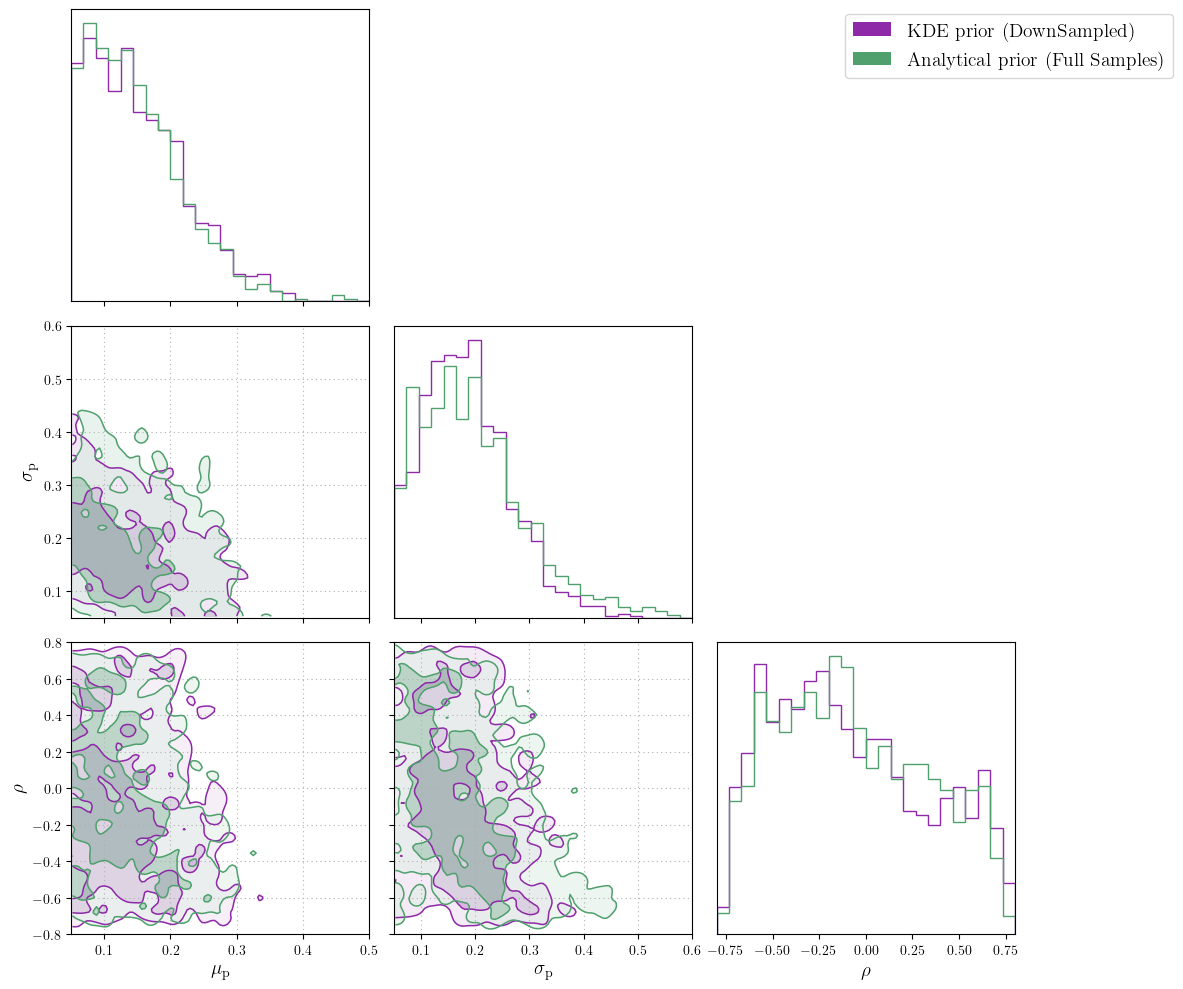

In [57]:
#Xp related parameter only

fig = plt.figure(figsize=(12,10))
#plot_colors = [plot_blue,plot_green]
to_plots = []
for processed_samps in [processed_samps_K0,processed_samps_A]:
    to_plot = {
    'muP':{'data':processed_samps[:,-3],'plot_bounds':(0.05,0.5),'label':r"$\mu_\mathrm{p}$"},
    'sigP':{'data':processed_samps[:,-2],'plot_bounds':(0.05,0.6),'label':r"$\sigma_\mathrm{p}$"},
    'rho':{'data':processed_samps[:,-1],'plot_bounds':(-0.8,0.8),'label':r"$\rho$"}
    }
    to_plots.append(to_plot)
plot_corner_overlay(fig,to_plots,plot_colors,labels=labels,bins=25,fill=True)
#fig.savefig('Corner_Xp_related.pdf',bbox_inches='tight')
plt.show()

KDE prior
Gaussian mean = 0.07 +0.04 -0.05
Gaussian SD = 0.11 +0.04 -0.04

Analytical prior
Gaussian mean = 0.06 +0.04 -0.04
Gaussian SD = 0.11 +0.04 -0.03



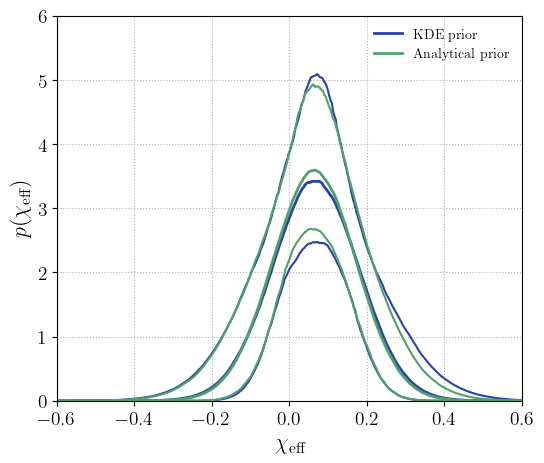

In [10]:
fig,ax = plt.subplots(figsize=(6,5))
x_grid = np.linspace(-1,1,1001)
labels=["KDE prior",'Analytical prior']
plot_colors = [plot_blue,plot_green,plot_purple]

for j,processed_samps in enumerate([processed_samps_K,processed_samps_A]):
    mu = processed_samps[:,-5]
    sig = processed_samps[:,-4]
    print(labels[j])
    print('Gaussian mean = {:.2f} +{:.2f} -{:.2f}'.format(np.median(mu),np.quantile(mu,0.95)-np.median(mu),np.median(mu)-np.quantile(mu,0.05)))
    print('Gaussian SD = {:.2f} +{:.2f} -{:.2f}'.format(np.median(sig),np.quantile(sig,0.95)-np.median(sig),np.median(sig)-np.quantile(sig,0.05)))
    print('')
    
    ys = np.zeros((mu.size,x_grid.size))
    for i in range(mu.size):
        y = calculate_Gaussian(x_grid,mu[i],sig[i]**2.,-1,1)
        #ax.plot(x_grid,y,color=plot_color,alpha=0.2,lw=0.2)
        ys[i,:] = y
    
    ax.plot(x_grid,np.quantile(ys,0.05,axis=0),color=plot_colors[j])
    ax.plot(x_grid,np.quantile(ys,0.50,axis=0),color=plot_colors[j],linewidth=2,label=labels[j])
    ax.plot(x_grid,np.quantile(ys,0.95,axis=0),color=plot_colors[j])
    
ax.legend(loc='upper right',frameon=False)
ax.set_xlim(-.6,.6)
ax.set_ylim(0,6)
ax.axes.grid(True,which='major',ls=':')
ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=16)
ax.set_ylabel(r'$p(\chi_\mathrm{eff})$',fontsize=16)
ax.tick_params(labelsize=14)
plt.savefig('PPD_Xeff.pdf')

In [11]:
mu_K = processed_samps_K[:,-3]
mu_A = processed_samps_A[:,-3]
sg_K = processed_samps_K[:,-2]
sg_A = processed_samps_A[:,-2]
rhoK = processed_samps_K[:,-1]
rhoA = processed_samps_A[:,-1]

In [12]:
PP_mu_p = []
PP_sg_p = []
PP_rho = []
for xp in np.linspace(0,1,10001):
    xmu = len(np.where(mu_K < xp)[0])/len(np.where(mu_K < 1)[0])
    xsg = len(np.where(sg_K < xp)[0])/len(np.where(sg_K < 1)[0])
    ymu = len(np.where(mu_A < xp)[0])/len(np.where(mu_A < 1)[0])
    ysg = len(np.where(sg_A < xp)[0])/len(np.where(sg_A < 1)[0])
    xp = xp*2 - 1
    xrh = len(np.where(rhoK < xp)[0])/len(np.where(rhoK < 1)[0])
    yrh = len(np.where(rhoA < xp)[0])/len(np.where(rhoA < 1)[0])
    if [xmu,ymu] not in PP_mu_p:
        PP_mu_p.append([xmu,ymu])
    if [xsg,ysg] not in PP_sg_p:
        PP_sg_p.append([xsg,ysg])
        
    if [xrh,yrh] not in PP_rho:
        PP_rho.append([xrh,yrh])
        
#np.array(PP_Xp)

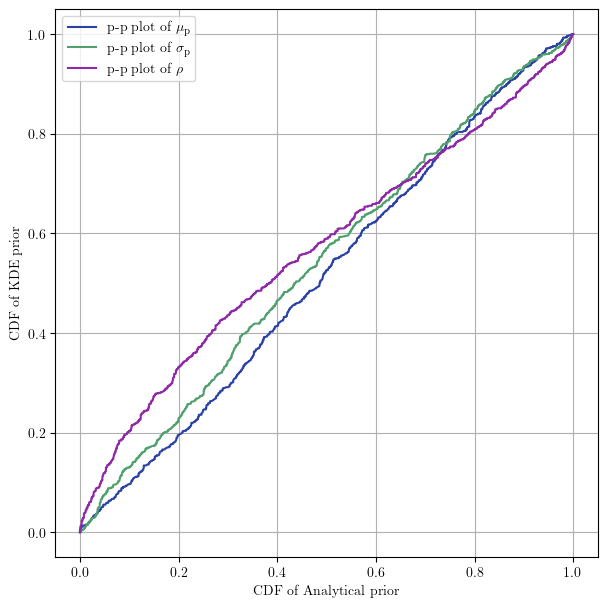

In [13]:
plt.figure(figsize = [6,6])
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.plot(np.array(PP_mu_p)[:,1],np.array(PP_mu_p)[:,0],label=r'p-p plot of $\mu_\mathrm{p}$',color=plot_blue)
plt.plot(np.array(PP_sg_p)[:,1],np.array(PP_sg_p)[:,0],label=r'p-p plot of $\sigma_\mathrm{p}$',color=plot_green)
plt.plot(np.array(PP_rho)[:,1],np.array(PP_rho)[:,0],label=r'p-p plot of $\rho$',color=plot_purple)
plt.tight_layout()
plt.ylabel('CDF of KDE prior')
plt.xlabel('CDF of Analytical prior')
plt.grid()
plt.legend()
plt.show()

KDE prior
Gaussian mean = 0.13 +0.13 -0.07
Gaussian SD = 0.17 +0.19 -0.10

Analytical prior
Gaussian mean = 0.14 +0.14 -0.08
Gaussian SD = 0.18 +0.21 -0.11



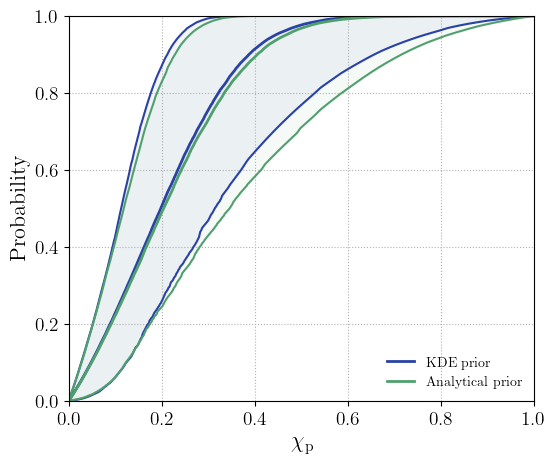

In [14]:
fig,ax = plt.subplots(figsize=(6,5))
x_grid = np.linspace(0,1,1001)
labels=["KDE prior",'Analytical prior']
plot_colors = [plot_blue,plot_green,plot_purple]

yss = []
for j,processed_samps in enumerate([processed_samps_K,processed_samps_A]):
    mu = processed_samps[:,-3]
    sig = processed_samps[:,-2]
    print(labels[j])
    print('Gaussian mean = {:.2f} +{:.2f} -{:.2f}'.format(np.median(mu),np.quantile(mu,0.95)-np.median(mu),np.median(mu)-np.quantile(mu,0.05)))
    print('Gaussian SD = {:.2f} +{:.2f} -{:.2f}'.format(np.median(sig),np.quantile(sig,0.95)-np.median(sig),np.median(sig)-np.quantile(sig,0.05)))
    print('')
    ys = np.zeros((mu.size,x_grid.size))
    for i in range(mu.size):
        y = calculate_Gaussian(x_grid,mu[i],sig[i]**2.,0,1)
        #ax.plot(x_grid,y,color=plot_color,alpha=0.2,lw=0.2)
        ys[i,:] = np.cumsum(y)/np.cumsum(y)[-1]
    
    ax.plot(x_grid,np.quantile(ys,0.05,axis=0),color=plot_colors[j])
    ax.plot(x_grid,np.quantile(ys,0.50,axis=0),color=plot_colors[j],linewidth=2,label=labels[j])
    ax.plot(x_grid,np.quantile(ys,0.95,axis=0),color=plot_colors[j])
    ax.fill_between(x_grid,np.quantile(ys,0.95,axis=0),np.quantile(ys,0.05,axis=0),color=plot_colors[j],alpha=0.05)
    yss.append(ys)
ax.legend(loc='best',frameon=False)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.axes.grid(True,which='major',ls=':')
ax.set_xlabel(r'$\chi_\mathrm{p}$',fontsize=16)
ax.set_ylabel(r'Probability',fontsize=16)
ax.tick_params(labelsize=14)
plt.savefig('CDF_Xp.pdf')

KDE prior
Gaussian mean = 0.07 +0.04 -0.05
Gaussian SD = 0.11 +0.04 -0.04

Analytical prior
Gaussian mean = 0.06 +0.04 -0.04
Gaussian SD = 0.11 +0.04 -0.03



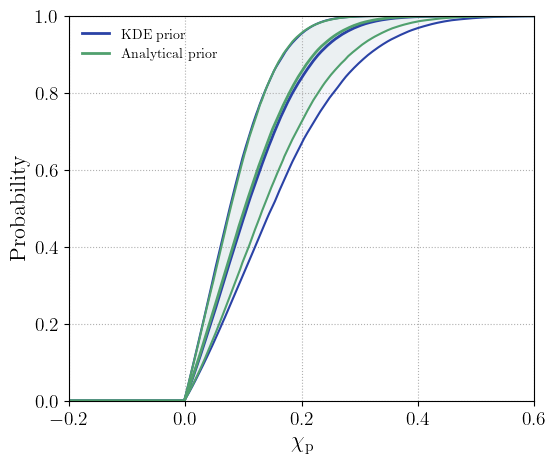

In [15]:
fig,ax = plt.subplots(figsize=(6,5))
x_grid = np.linspace(-1,1,1001)
labels=["KDE prior",'Analytical prior']
plot_colors = [plot_blue,plot_green,plot_purple]

yss = []
for j,processed_samps in enumerate([processed_samps_K,processed_samps_A]):
    mu = processed_samps[:,-5]
    sig = processed_samps[:,-4]
    print(labels[j])
    print('Gaussian mean = {:.2f} +{:.2f} -{:.2f}'.format(np.median(mu),np.quantile(mu,0.95)-np.median(mu),np.median(mu)-np.quantile(mu,0.05)))
    print('Gaussian SD = {:.2f} +{:.2f} -{:.2f}'.format(np.median(sig),np.quantile(sig,0.95)-np.median(sig),np.median(sig)-np.quantile(sig,0.05)))
    print('')
    ys = np.zeros((mu.size,x_grid.size))
    for i in range(mu.size):
        y = calculate_Gaussian(x_grid,mu[i],sig[i]**2.,0,1)
        #ax.plot(x_grid,y,color=plot_color,alpha=0.2,lw=0.2)
        ys[i,:] = np.cumsum(y)/np.cumsum(y)[-1]
    
    ax.plot(x_grid,np.quantile(ys,0.05,axis=0),color=plot_colors[j])
    ax.plot(x_grid,np.quantile(ys,0.50,axis=0),color=plot_colors[j],linewidth=2,label=labels[j])
    ax.plot(x_grid,np.quantile(ys,0.95,axis=0),color=plot_colors[j])
    ax.fill_between(x_grid,np.quantile(ys,0.95,axis=0),np.quantile(ys,0.05,axis=0),color=plot_colors[j],alpha=0.05)
    yss.append(ys)
ax.legend(loc='best',frameon=False)
ax.set_xlim(-.2,.6)
ax.set_ylim(0,1)
ax.axes.grid(True,which='major',ls=':')
ax.set_xlabel(r'$\chi_\mathrm{p}$',fontsize=16)
ax.set_ylabel(r'Probability',fontsize=16)
ax.tick_params(labelsize=14)
#plt.savefig('CDF_Xp.pdf')

In [16]:
for p in [0.2,0.8,.9,.99]:
    
    for k in range(2):
        lst = []
        for i in range(yss[1].shape[1]):
            lst.append(x_grid[np.min(np.where(yss[k][i,:] > p))])
        
        print('When we adopt the {} prior, P^[-1]({}) is:'.format(['KDE','Analytical'][k],p))
        print(np.median(lst),'+',np.quantile(lst,q=0.95)-np.median(lst),'-',-(np.quantile(lst,q=0.05)-np.median(lst)))

When we adopt the KDE prior, P^[-1](0.2) is:
0.04400000000000004 + 0.020000000000000018 - 0.01200000000000001
When we adopt the Analytical prior, P^[-1](0.2) is:
0.04200000000000004 + 0.016000000000000014 - 0.010000000000000009
When we adopt the KDE prior, P^[-1](0.8) is:
0.18599999999999994 + 0.07000000000000006 - 0.04799999999999982
When we adopt the Analytical prior, P^[-1](0.8) is:
0.17999999999999994 + 0.04800000000000004 - 0.04399999999999982
When we adopt the KDE prior, P^[-1](0.9) is:
0.23199999999999998 + 0.08600000000000008 - 0.06000000000000005
When we adopt the Analytical prior, P^[-1](0.9) is:
0.22199999999999998 + 0.062000000000000055 - 0.05400000000000005
When we adopt the KDE prior, P^[-1](0.99) is:
0.3440000000000001 + 0.1259999999999999 - 0.09400000000000008
When we adopt the Analytical prior, P^[-1](0.99) is:
0.32800000000000007 + 0.09199999999999986 - 0.07600000000000007


In [17]:
x_grid[np.min(np.where(x_grid>=0.2))]

0.20199999999999996

In [18]:
for xp in [.05,.1,.2,.3,.4,.5,.6,.7,.8,.9]:
    
    for k in range(2):
        target_index = np.min(np.where(x_grid>=xp))
        median = np.median(yss[k][:,target_index])
        upper = np.quantile(yss[k][:,target_index],q = 0.95)
        lower = np.quantile(yss[k][:,target_index],q = 0.05)
        
        print('When we adopt the {} prior, P(Xp < {}) is:'.format(['KDE','Analytical'][k],xp))
        print('{:.2f} +{:.2f} -{:.2f}'.format(median,upper-median,median-lower))
    print('')

When we adopt the KDE prior, P(Xp < 0.05) is:
0.23 +0.10 -0.08
When we adopt the Analytical prior, P(Xp < 0.05) is:
0.24 +0.08 -0.07

When we adopt the KDE prior, P(Xp < 0.1) is:
0.47 +0.17 -0.15
When we adopt the Analytical prior, P(Xp < 0.1) is:
0.49 +0.14 -0.12

When we adopt the KDE prior, P(Xp < 0.2) is:
0.84 +0.11 -0.17
When we adopt the Analytical prior, P(Xp < 0.2) is:
0.86 +0.10 -0.13

When we adopt the KDE prior, P(Xp < 0.3) is:
0.97 +0.02 -0.09
When we adopt the Analytical prior, P(Xp < 0.3) is:
0.98 +0.02 -0.06

When we adopt the KDE prior, P(Xp < 0.4) is:
1.00 +0.00 -0.03
When we adopt the Analytical prior, P(Xp < 0.4) is:
1.00 +0.00 -0.01

When we adopt the KDE prior, P(Xp < 0.5) is:
1.00 +0.00 -0.01
When we adopt the Analytical prior, P(Xp < 0.5) is:
1.00 +0.00 -0.00

When we adopt the KDE prior, P(Xp < 0.6) is:
1.00 +0.00 -0.00
When we adopt the Analytical prior, P(Xp < 0.6) is:
1.00 +0.00 -0.00

When we adopt the KDE prior, P(Xp < 0.7) is:
1.00 +0.00 -0.00
When we adop

In [19]:
np.median(lst),np.quantile(lst,q=0.95)-np.median(lst),-(np.quantile(lst,q=0.05)-np.median(lst))

(0.32800000000000007, 0.09199999999999986, 0.07600000000000007)

In [20]:
np.median(yss[0][:,np.min(np.where(x_grid>=0.2))])

0.8441399376121912

In [21]:
def logp_powerLawPeak_components(c,sampleDict,injectionDict,priorDict,sampler='emcee',chi_min=-1):

    """
    This is written based on logp_powerLaoPeak, but it returns each factor within the likelihood separately.
    """

    to_return = {}

    #logP = 0.

    # Read parameters
    lmbda = c[0]
    mMax = c[1]
    m0 = c[2]
    sigM = c[3]
    fPeak = c[4]
    bq = c[5]
    kappa = c[6]
    mu_eff = c[7]
    sigma_eff = c[8]
    mu_p = c[9]
    sigma_p = c[10]
    rho = c[11]

    # Call priors as necessary
    if sampler=="emcee":

        # Flat priors, reject samples past boundaries
        if not inPrior_powerLawPeak(c,priorDict):
            to_return["log_prior"] = -np.inf
        else:
            to_return["log_prior"] = -kappa**2./(2.*priorDict['sig_kappa']**2.)

        # Gaussian prior on kappa
        #logP += -kappa**2./(2.*priorDict['sig_kappa']**2.)

    # Unpack injections
    m1_det = injectionDict['m1']
    m2_det = injectionDict['m2']
    z_det = injectionDict['z']
    dVdz_det = injectionDict['dVdz']
    Xeff_det = injectionDict['Xeff']
    Xp_det = injectionDict['Xp']
    pop_reweight = injectionDict['weights']
    q_det = m2_det/m1_det
    mtot_det = m1_det+m2_det

    mMin = priorDict['mMin']

    # Reweight injection probabilities
    p_det_Xeff_Xp = calculate_Gaussian_2D(Xeff_det, Xp_det, mu_eff, sigma_eff**2, mu_p, sigma_p**2., rho, chi_min=chi_min)
    p_det_m2 = (1.+bq)*np.power(m2_det,bq)/(np.power(m1_det,1.+bq)-mMin**(1.+bq))
    p_det_m2[m2_det<mMin] = 0.
    p_det_z = dVdz_det*np.power(1.+z_det,kappa-1.)

    # PLPeak distribution on p(m1)
    p_det_m1_pl = (1.+lmbda)*m1_det**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
    p_det_m1_pl[m1_det>mMax] = 0
    p_det_m1_peak = np.exp(-0.5*(m1_det-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
    p_det_m1 = fPeak*p_det_m1_peak + (1.-fPeak)*p_det_m1_pl

    # Construct full weighting factors
    det_weights = p_det_Xeff_Xp*p_det_m1*p_det_m2*p_det_z*pop_reweight
    if np.max(det_weights)==0:
        to_return["log_detEff"] = -np.inf
    else:
        # Check for sufficient sampling size
        # Specifically require 4*Ndet effective detections, according to https://arxiv.org/abs/1904.10879
        nEvents = len(sampleDict)
        Nsamp = np.sum(det_weights)**2/np.sum(det_weights**2)
        if Nsamp<=4*nEvents:
            if sampler=="emcee": print("Insufficient mock detections:",c)
            #return -np.inf
            to_return["log_detEff"] = -np.inf
        else:
            # Add detection efficiency term to log likelihood
            #log_detEff = -nEvents*np.log(np.sum(det_weights))
            #logP += log_detEff
            to_return["log_detEff"] = -nEvents*np.log(np.sum(det_weights))

    # Loop across samples
    for event in sampleDict:

        # Grab samples
        m1_sample = sampleDict[event]['m1']
        m2_sample = sampleDict[event]['m2']
        Xeff_sample = sampleDict[event]['Xeff']
        Xp_sample = sampleDict[event]['Xp']
        z_sample = sampleDict[event]['z']
        spin_prior = sampleDict[event]['joint_priors']
        weights = sampleDict[event]['weights']
        q_sample = m2_sample/m1_sample
        
        # Chi probability - Gaussian: P(chi_eff | mu, sigma2)
        p_Chi = calculate_Gaussian_2D(Xeff_sample, Xp_sample, mu_eff, sigma_eff**2., mu_p, sigma_p**2., rho, chi_min=chi_min)

        # p(m1)
        p_m1_pl = (1.+lmbda)*m1_sample**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
        p_m1_pl[m1_sample>mMax] = 0.
        p_m1_peak = np.exp(-0.5*(m1_sample-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
        p_m1 = fPeak*p_m1_peak + (1.-fPeak)*p_m1_pl
        old_m1_prior = np.ones(m1_sample.size)
        
        # p(m2)
        p_m2 = (1.+bq)*np.power(m2_sample,bq)/(np.power(m1_sample,1.+bq)-mMin**(1.+bq))
        old_m2_prior = np.ones(m2_sample.size)
        p_m2[m2_sample<mMin]=0

        # p(z)
        p_z = np.power(1.+z_sample,kappa-1.)
        old_pz_prior = (1.+z_sample)**(2.7-1.)
        
        # Evaluate marginalized likelihood
        nSamples = p_Chi.size

        integrand = p_Chi*p_m1*p_m2*p_z*weights/spin_prior/old_m1_prior/old_m2_prior/old_pz_prior
        neff_singleEvent = np.sum(integrand)**2/np.sum(integrand**2)
        if neff_singleEvent<10:
            #print(event,neff_singleEvent)
            to_return[event] = -np.inf
        else:
            to_return[event] = np.log(np.sum(integrand)/nSamples)

        # Summation
        #logP += np.log(pEvidence)

    return to_return


In [22]:
injectionDict_K = np.load("../code/injectionDict_rerun_directMixture_FAR_1_in_1_K.pickle", allow_pickle=True)
injectionDict_A = np.load("../code/injectionDict_rerun_directMixture_FAR_1_in_1_A.pickle", allow_pickle=True)

In [23]:
sampleDict_K = np.load("../input/sampleDict_FAR_1_in_1_yr_rerun_K.pickle", allow_pickle=True)
sampleDict_K.pop('S190814bv')
sampleDict_A = np.load("../input/sampleDict_FAR_1_in_1_yr_rerun_A.pickle", allow_pickle=True)
sampleDict_A.pop('S190814bv')

{'Xeff': array([ 0.01601918, -0.01816856, -0.00821549, ..., -0.00760843,
         0.06549137, -0.02164504]),
 'Xp': array([0.03676729, 0.03335779, 0.0396707 , ..., 0.0175947 , 0.06547825,
        0.06193204]),
 'joint_priors': array([11.18661541, 10.17555979, 12.05888626, ..., 10.97349505,
         5.75971265, 10.70424961]),
 'Xeff_priors': array([2.12291823, 2.08783746, 2.22745859, ..., 2.22685679, 1.54372175,
        2.04701411]),
 'weights': array([ 9.91233616,  9.98457354, 10.0130659 , ..., 10.58775836,
         9.9400935 , 10.2554622 ]),
 'm1': array([23.50275705, 22.78131867, 23.49281885, ..., 23.37968017,
        24.14642089, 23.16648889]),
 'm2': array([2.55314115, 2.60654509, 2.54037466, ..., 2.62204325, 2.50780049,
        2.60097406]),
 'a1': array([0.04858394, 0.01944872, 0.04033903, ..., 0.00574076, 0.01502557,
        0.05925824]),
 'a2': array([0.40054257, 0.36675412, 0.15186097, ..., 0.22066326, 0.97160621,
        0.74717303]),
 'cost1': array([ 0.65367115, -0.92472314

In [24]:
sampleDict_A.keys()

dict_keys(['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729', 'GW170809', 'GW170814', 'GW170818', 'GW170823', 'S190408an', 'S190412m', 'S190413ac', 'S190413i', 'S190421ar', 'S190503bf', 'S190512at', 'S190513bm', 'S190517h', 'S190519bj', 'S190521g', 'S190521r', 'S190527w', 'S190602aq', 'S190620e', 'S190630ag', 'S190701ah', 'S190706ai', 'S190707q', 'S190708ap', 'S190719an', 'S190720a', 'S190725t', 'S190727h', 'S190728q', 'S190731aa', 'S190803e', 'S190805bq', 'S190828j', 'S190828l', 'S190910s', 'S190915ak', 'S190924h', 'S190925ad', 'S190929d', 'S190930s', 'S191103a', 'S191105e', 'S191109d', 'S191127p', 'S191129u', 'S191204r', 'S191215w', 'S191216ap', 'S191222n', 'S191230an', 'S200112r', 'S200128d', 'S200129m', 'S200202ac', 'S200208q', 'S200209ab', 'S200216br', 'S200219ac', 'S200224ca', 'S200225q', 'S200302c', 'S200311bg', 'S200316bj'])

In [25]:
processed_samps = np.load('../results/processed_AllSamples_r00.npy','r')

In [26]:
#processed_samps = np.concatenate([np.array(processed_samps_A),np.array(processed_samps_K)])

In [27]:
processed_samps

memmap([[-3.27325707e+00,  8.36202995e+01,  3.35367482e+01, ...,
          1.05284306e-01,  3.61323832e-01, -9.41628775e-02],
        [-3.13850690e+00,  7.86273352e+01,  3.36529543e+01, ...,
          9.79724615e-02,  1.75481022e-01,  2.15739618e-02],
        [-3.18292359e+00,  7.95030800e+01,  3.61952832e+01, ...,
          8.72683579e-02,  1.96237605e-01, -3.26541485e-01],
        ...,
        [-3.03928344e+00,  8.22224299e+01,  3.40628115e+01, ...,
          1.20498942e-01,  7.46887641e-02,  4.83796721e-01],
        [-3.28020452e+00,  9.83467336e+01,  3.50222654e+01, ...,
          2.00633235e-01,  8.82876208e-02,  3.54474089e-01],
        [-3.30952786e+00,  9.71543450e+01,  3.64041391e+01, ...,
          2.55887510e-01,  2.22886906e-01, -4.39107171e-01]])

In [28]:
log_posterior_A_components = lambda p: logp_powerLawPeak_components(p, sampleDict_A, injectionDict_A, priorDict)

In [29]:
log_posterior_K_components = lambda p: logp_powerLawPeak_components(p, sampleDict_K, injectionDict_K, priorDict)


In [30]:
priorDict = {
    'lmbda':(-5,4),
    'mMax':(60,100),
    'm0':(20,100),
    'sigM':(1,10),
    'fPeak':(0,1),
    'bq':(-2,10),
    'sig_kappa':6.,
    'mu_eff':(-1,1),
    'sigma_eff':(0.05,1.),
    'mu_p':(0.05,1),
    'sigma_p':(0.05,1.),
    'rho':(-0.75,0.75),
    'mMin':5.
}

In [31]:
from gaussianLikelihoods import *
samples = {
    "lmbda": processed_samps[:, 0],
    "mMax": processed_samps[:, 1],
    "m0": processed_samps[:, 2],
    "sigM": processed_samps[:, 3],
    "fPeak": processed_samps[:, 4],
    "bq": processed_samps[:, 5],
    "kappa": processed_samps[:, 6],
    "mu_eff": processed_samps[:, 7],
    "sigma_eff": processed_samps[:, 8],
    "mu_p": processed_samps[:, 9],
    "sigma_p": processed_samps[:, 10],
    "rho": processed_samps[:, 11],
}
N_samps = len(samples["lmbda"])
param_names = ["lmbda", "mMax", "m0", "sigM", "fPeak", "bq", "kappa", "mu_eff", "sigma_eff", "mu_p", "sigma_p", "rho"]
samples_list = [[samples[k][i] for k in param_names] for i in range(N_samps)]
logps_K_components = []
logps_A_components = []
for i in tqdm(list(range(N_samps))):
#    logps_KDE.append(log_posterior_KDE(samples_list[i]))
#    logps_Analytical.append(log_posterior_Analytical(samples_list[i]))
    logps_K_components.append(log_posterior_K_components(samples_list[i]))
    logps_A_components.append(log_posterior_A_components(samples_list[i]))

  0%|          | 0/1120 [00:00<?, ?it/s]

In [32]:
logps_K_components = dict((k, np.array([logps_K_components[i][k] for i in range(N_samps)])) for k in logps_K_components[0].keys())
logps_A_components = dict((k, np.array([logps_A_components[i][k] for i in range(N_samps)])) for k in logps_A_components[0].keys())

In [33]:
len(logps_K_components['log_prior'])

1120

  0%|          | 0/71 [00:00<?, ?it/s]

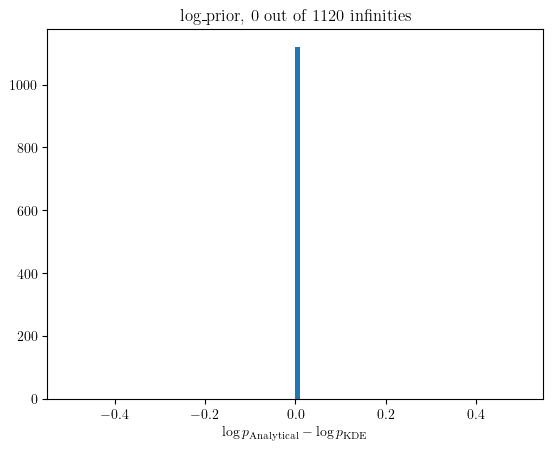

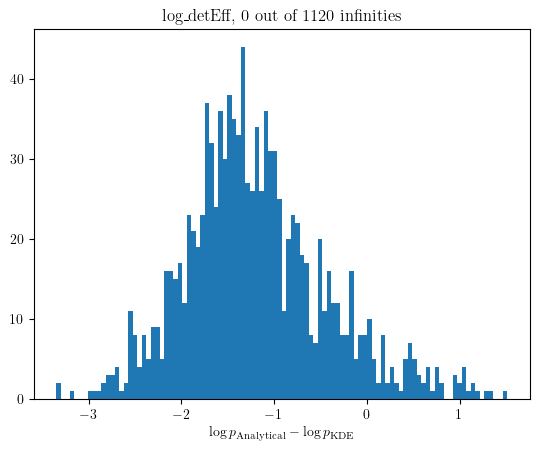

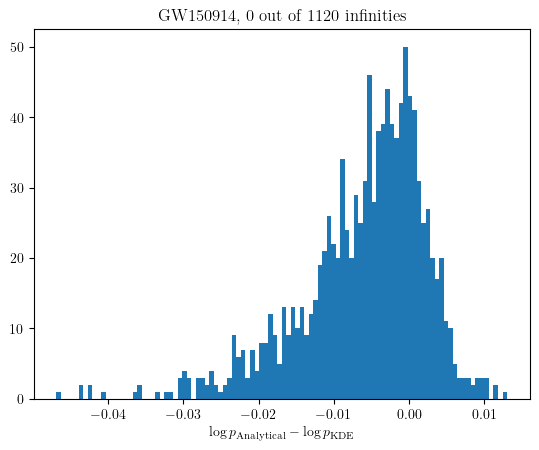

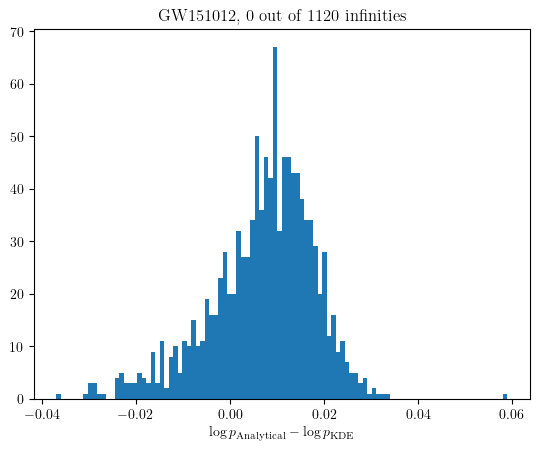

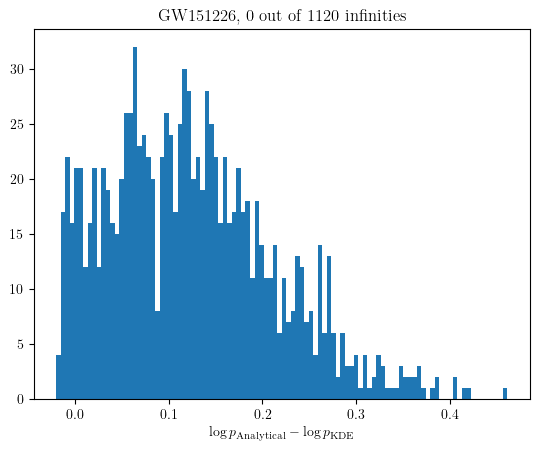

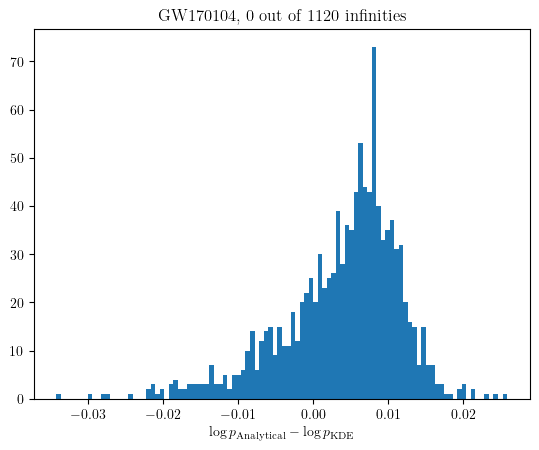

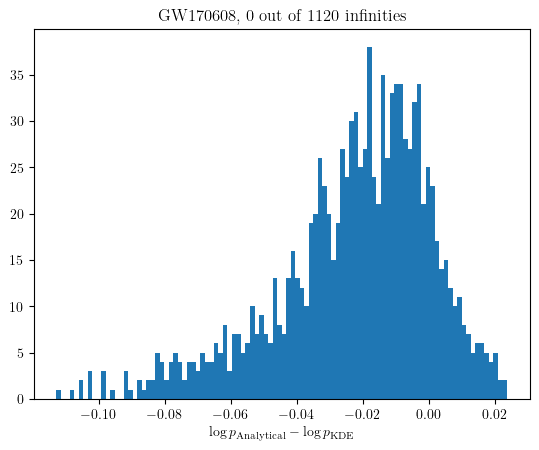

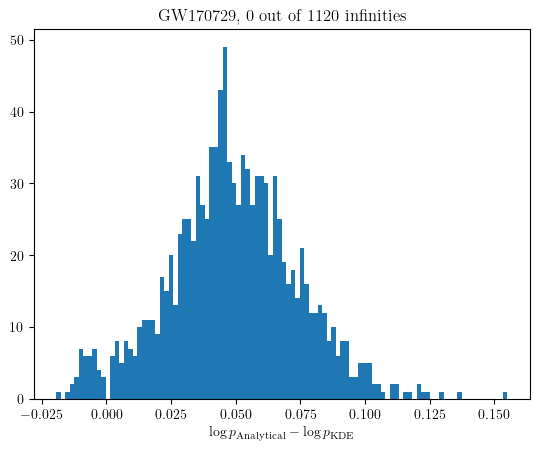

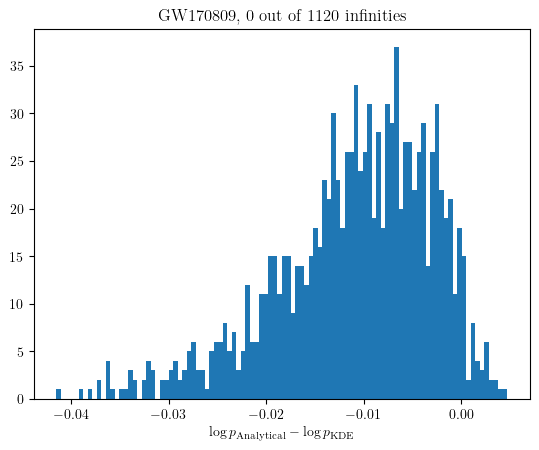

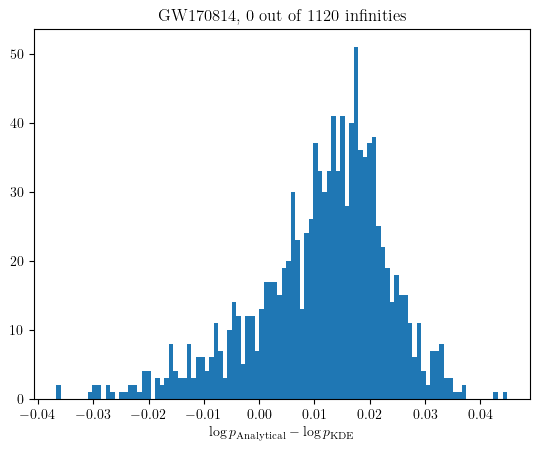

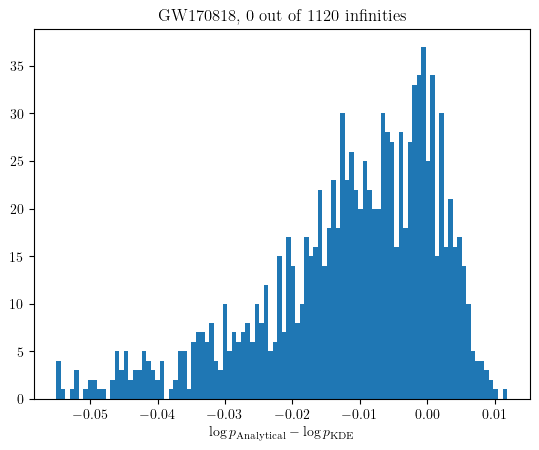

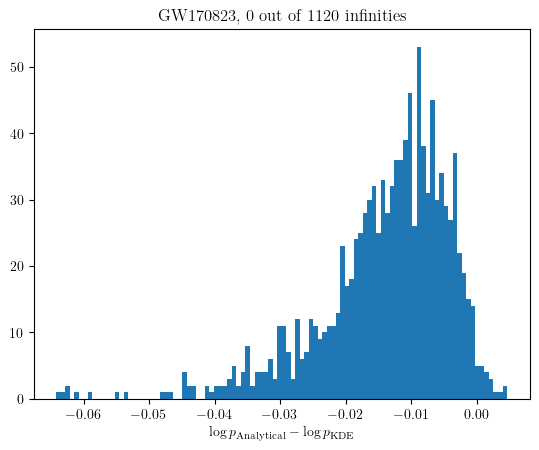

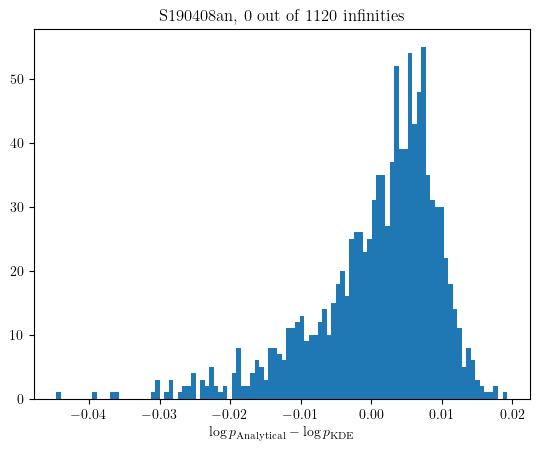

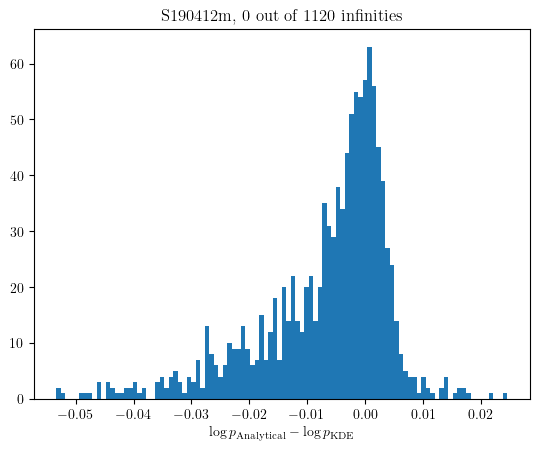

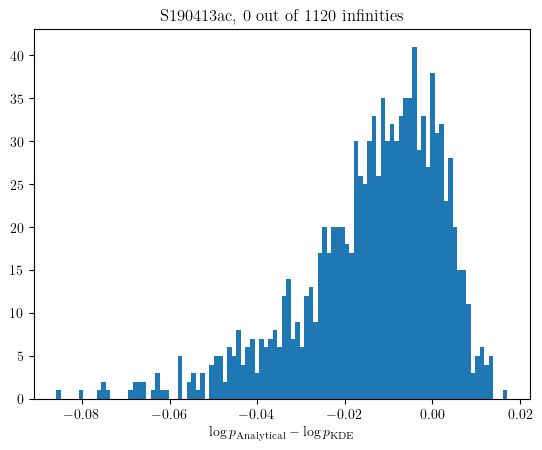

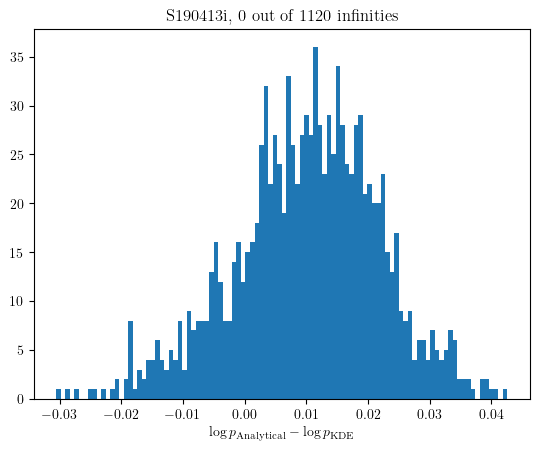

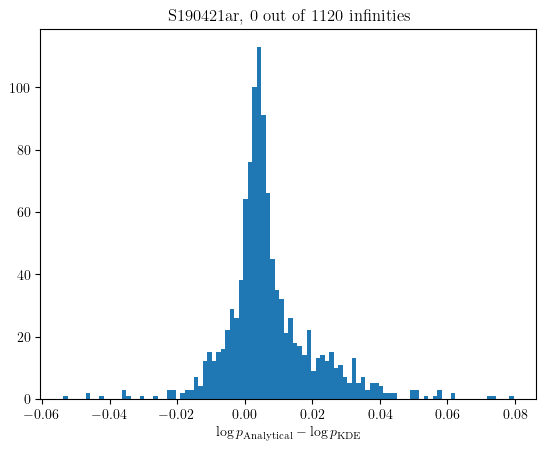

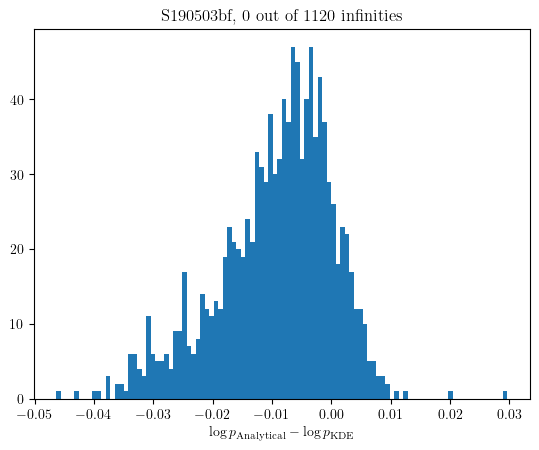

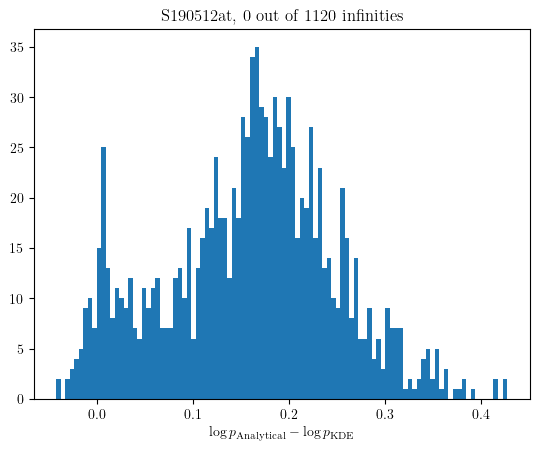

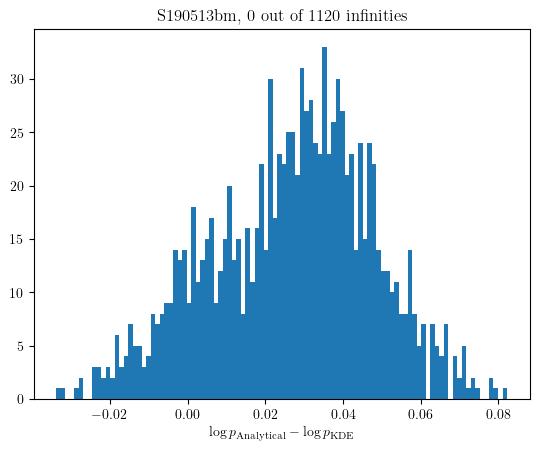

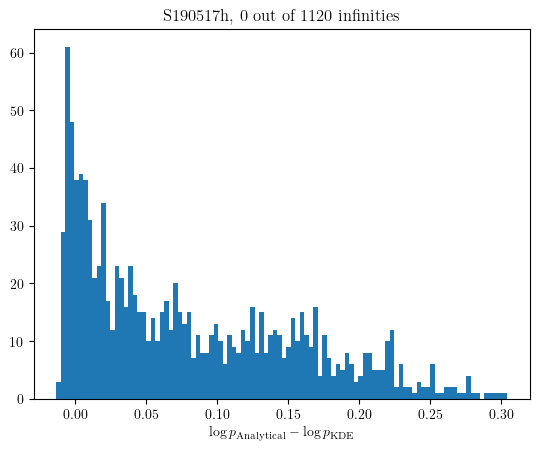

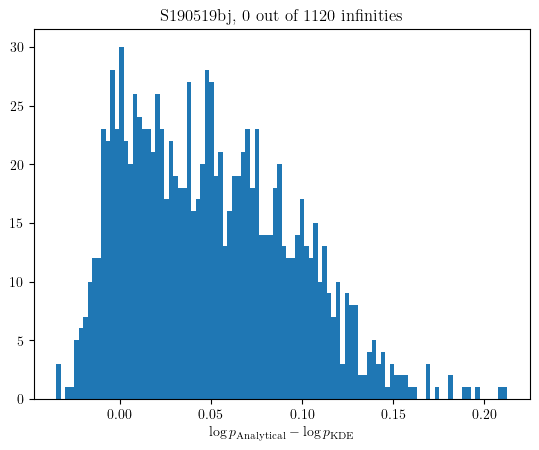

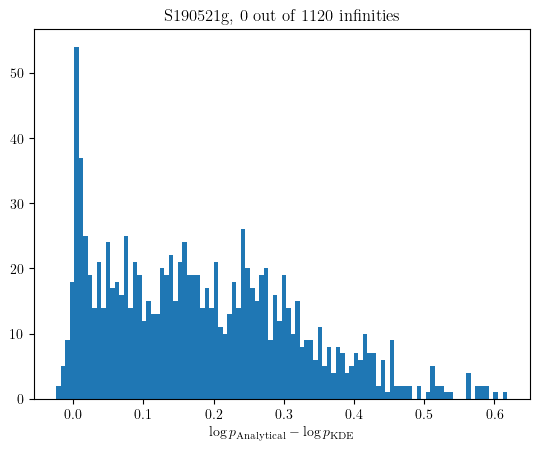

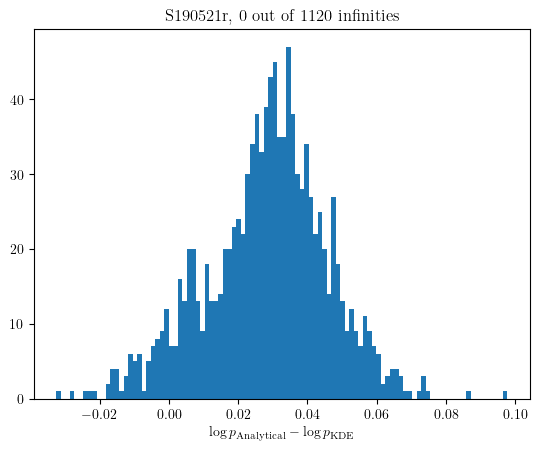

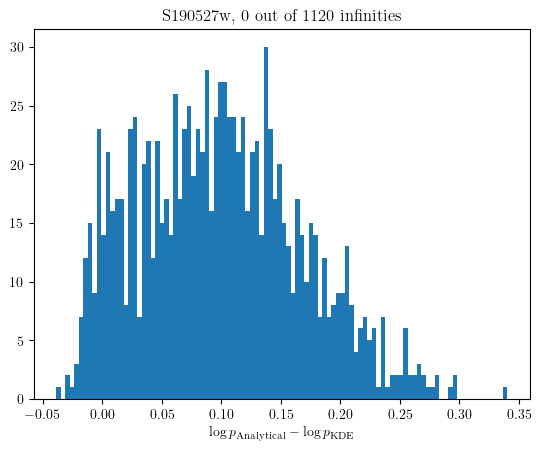

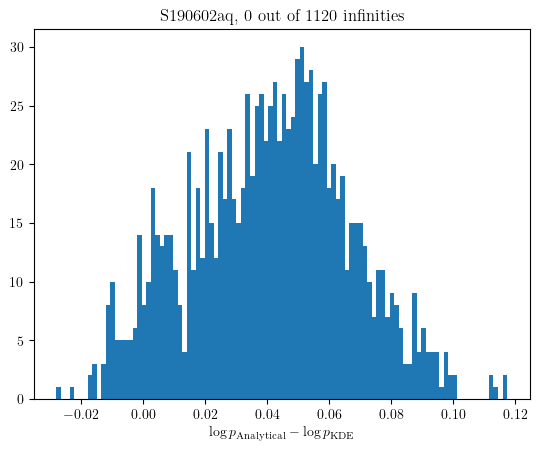

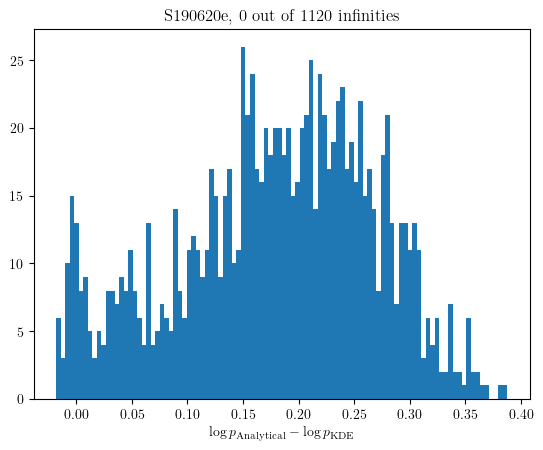

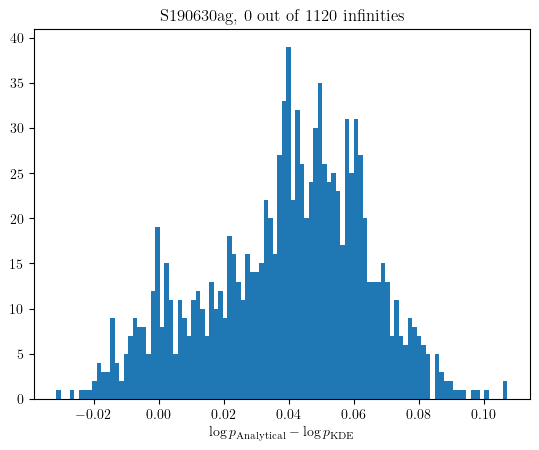

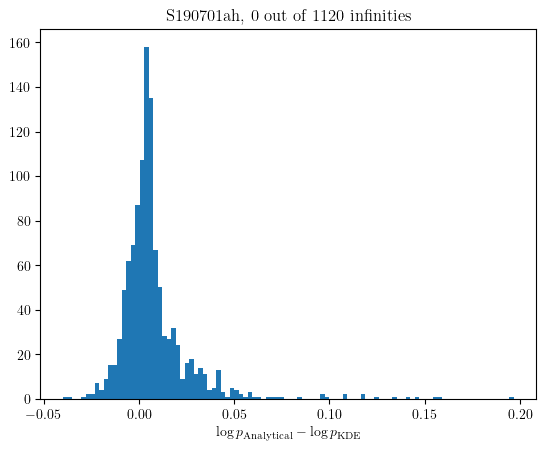

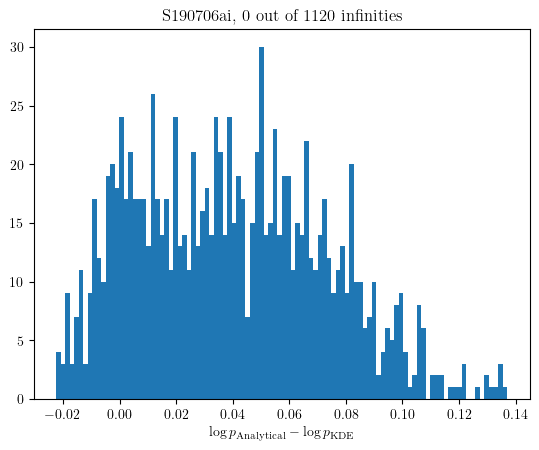

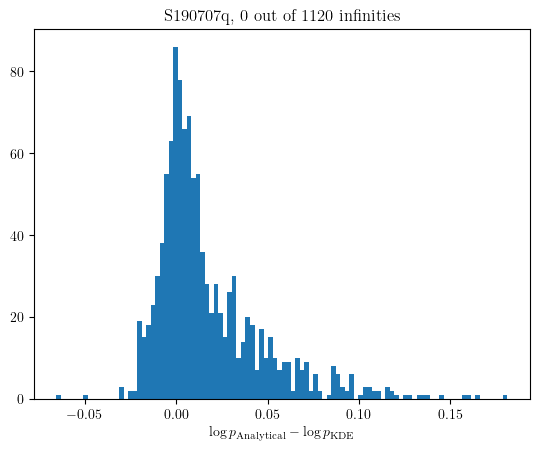

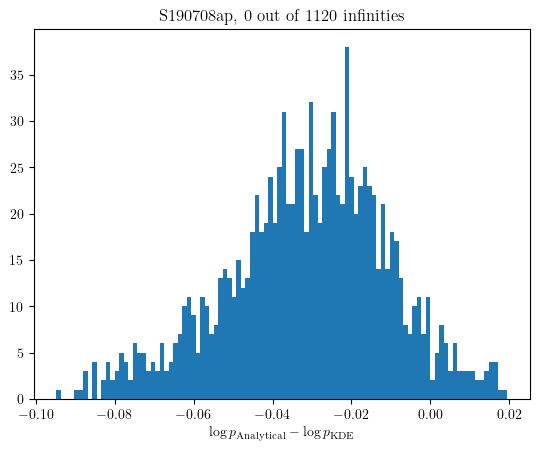

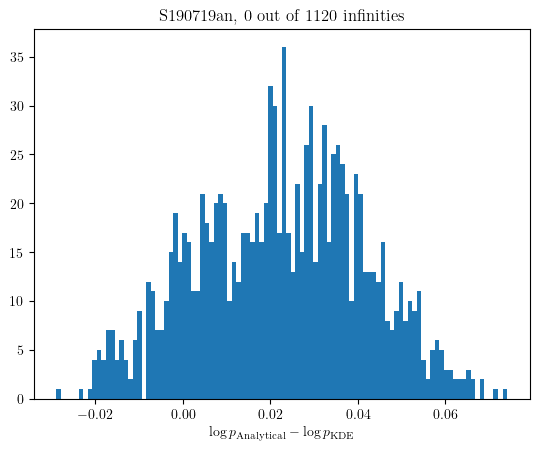

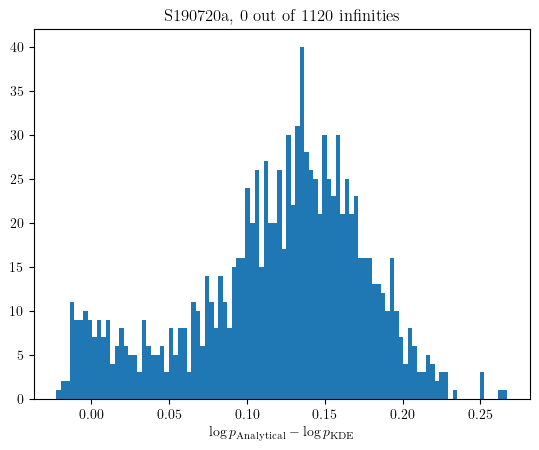

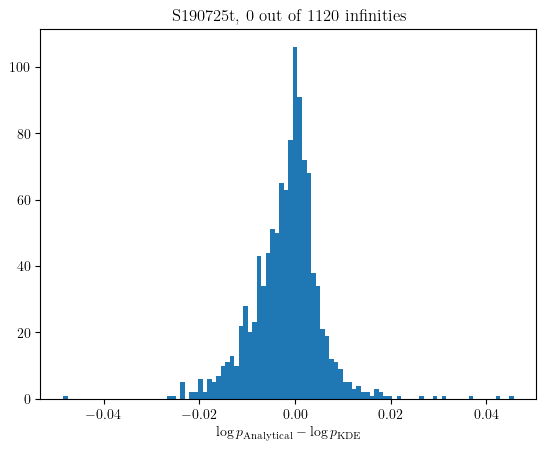

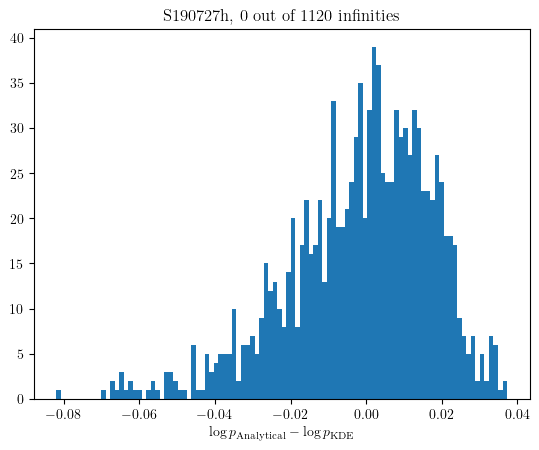

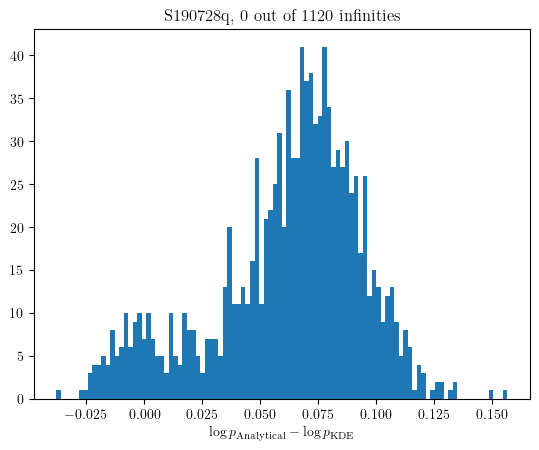

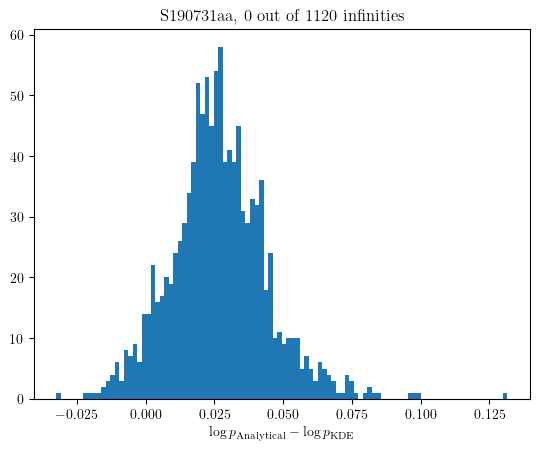

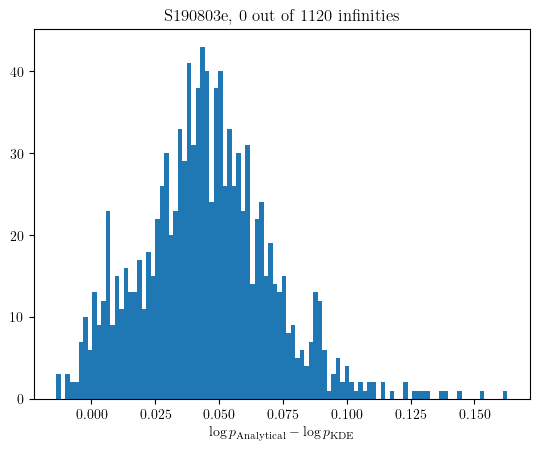

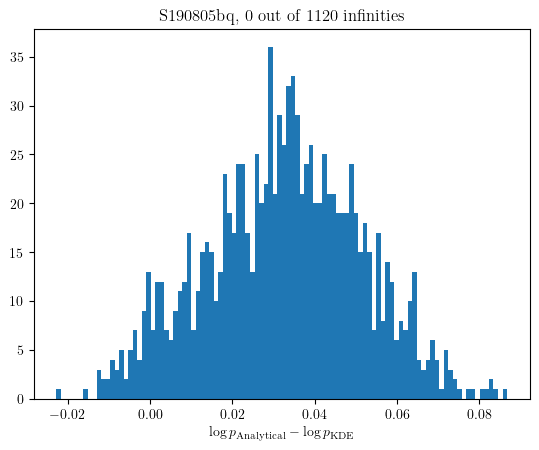

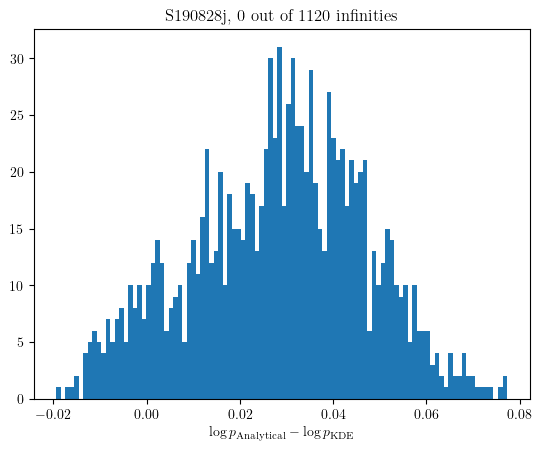

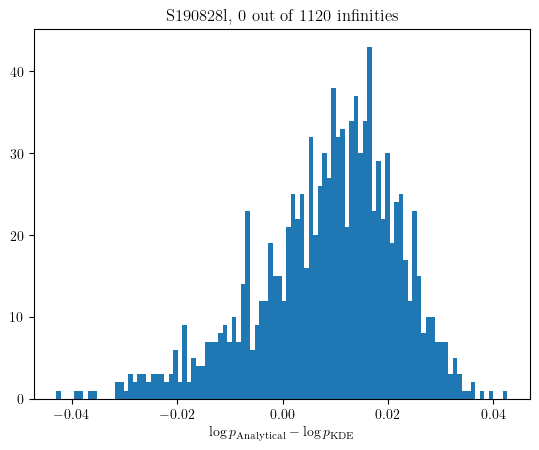

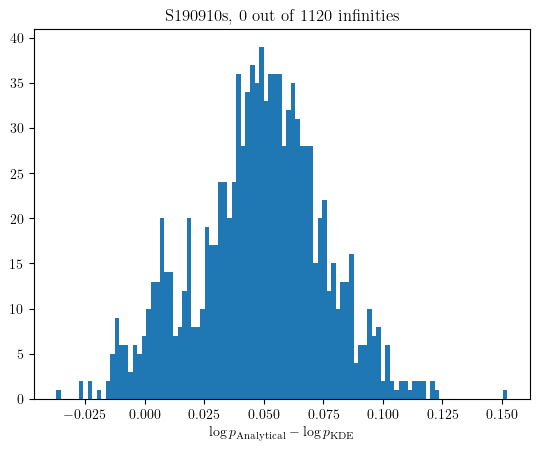

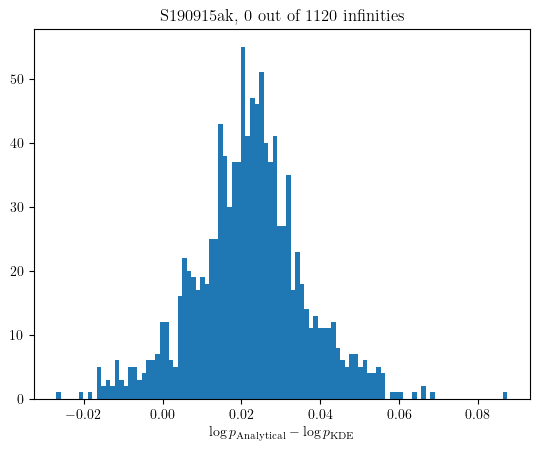

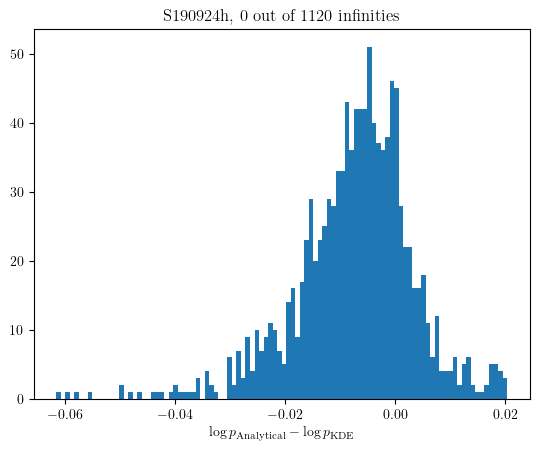

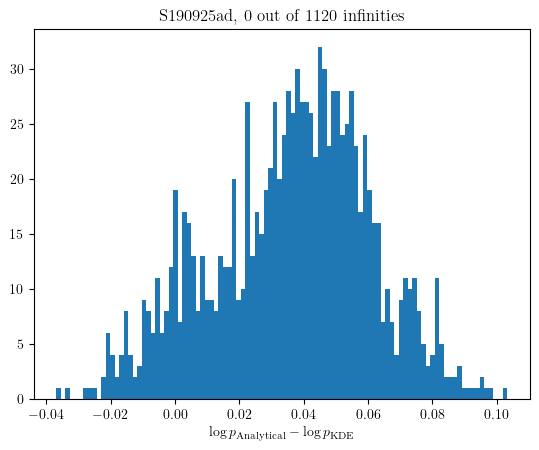

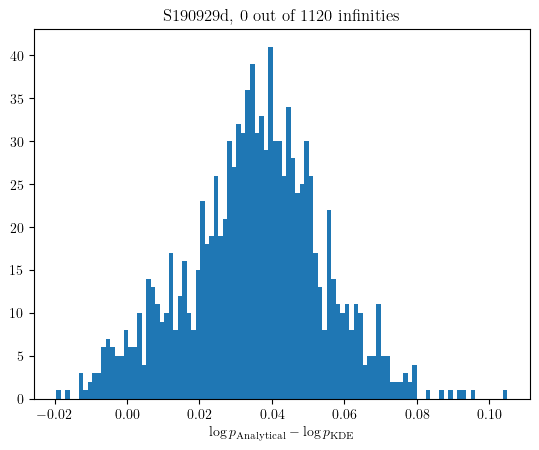

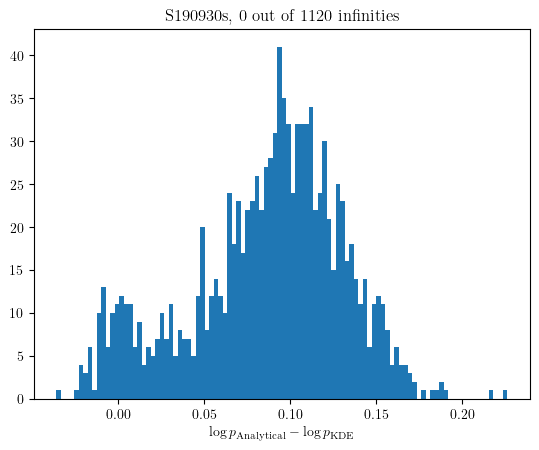

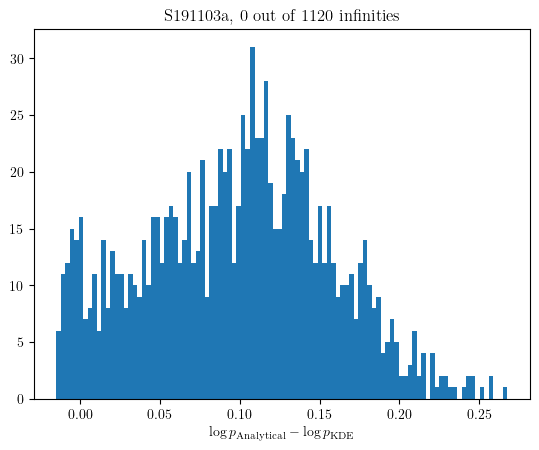

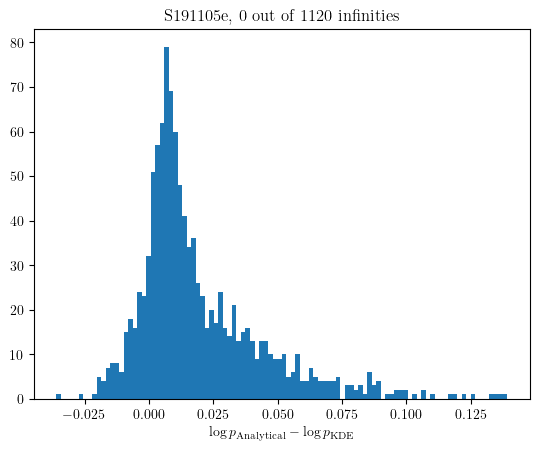

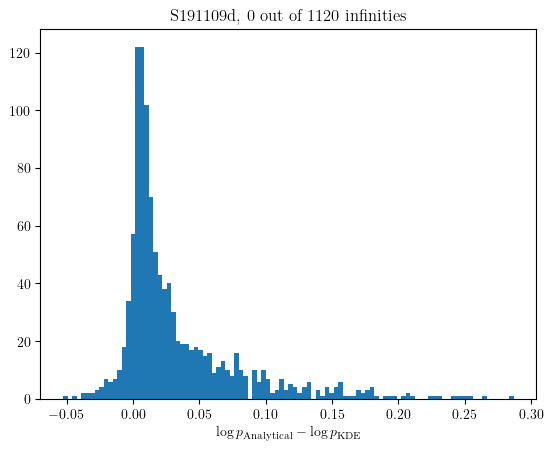

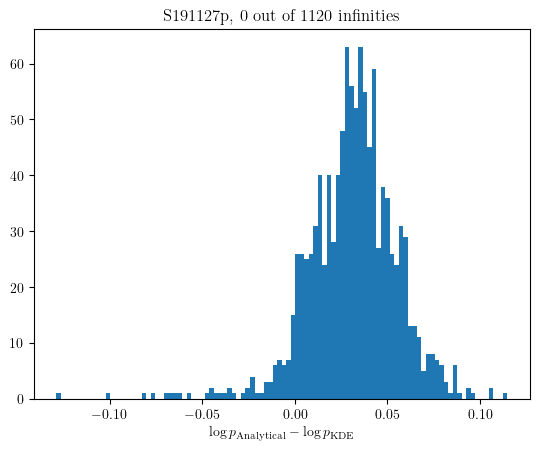

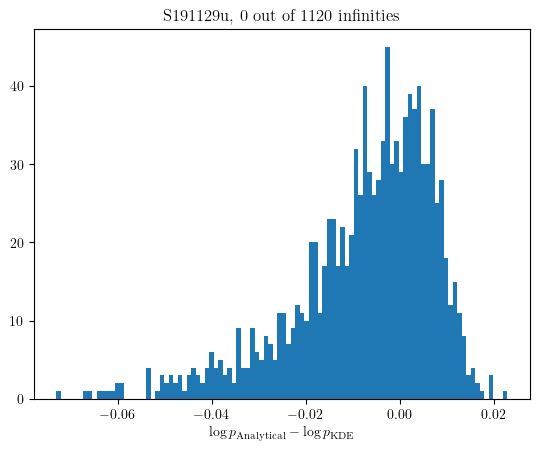

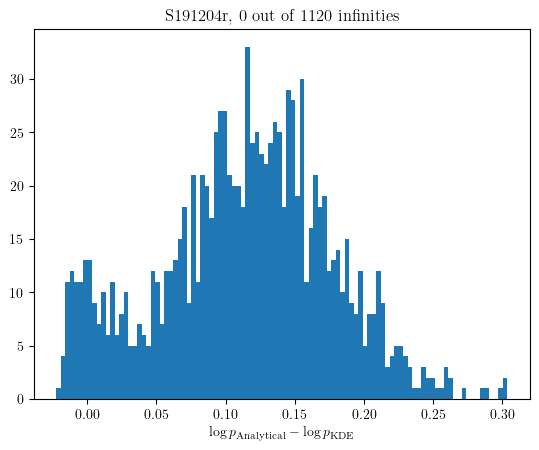

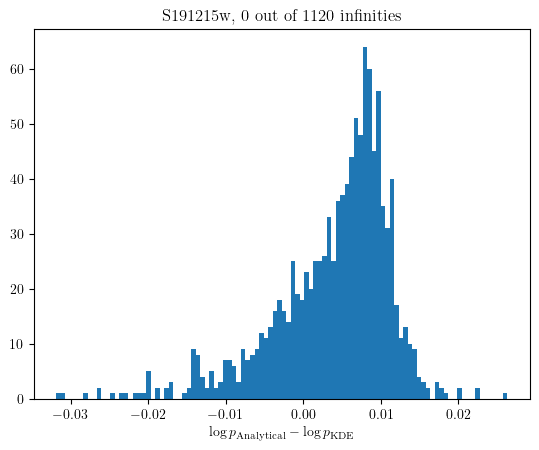

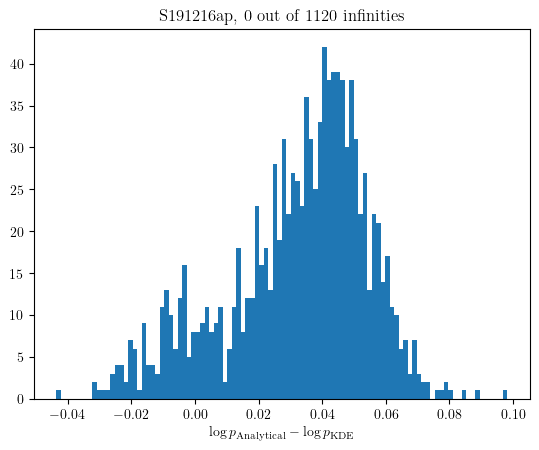

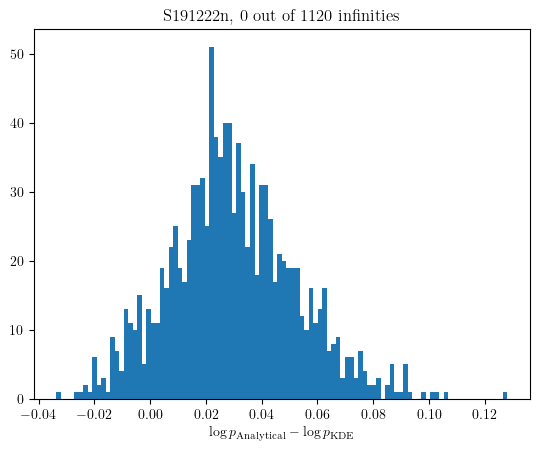

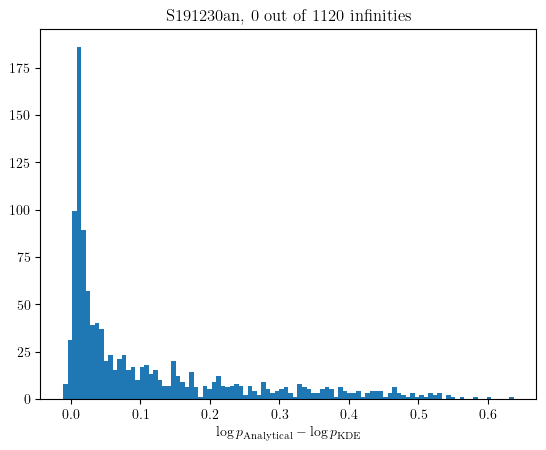

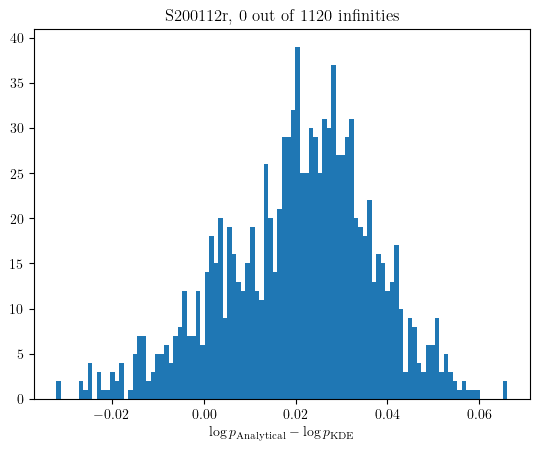

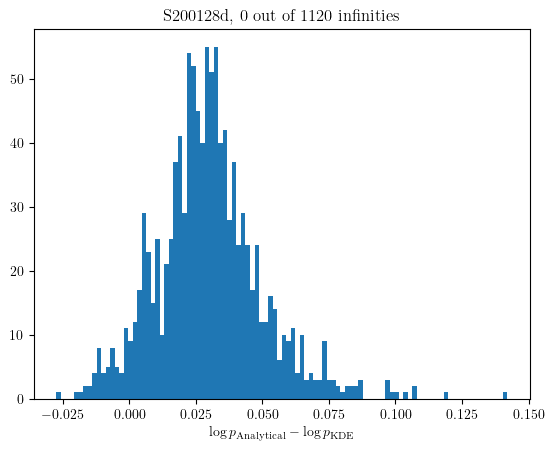

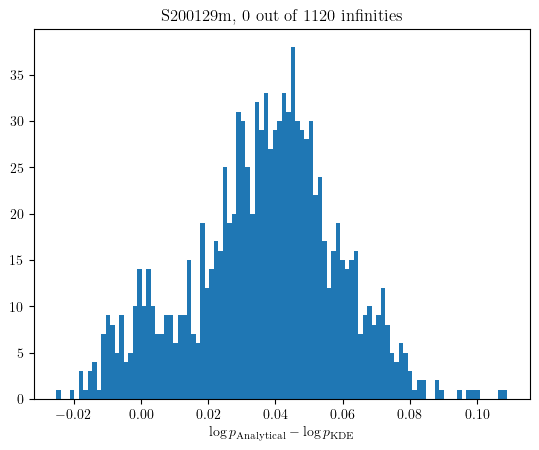

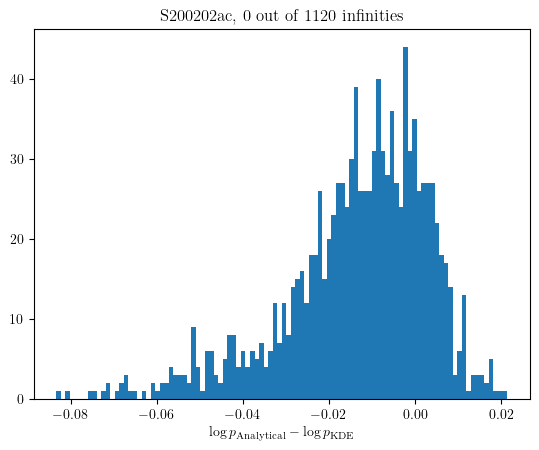

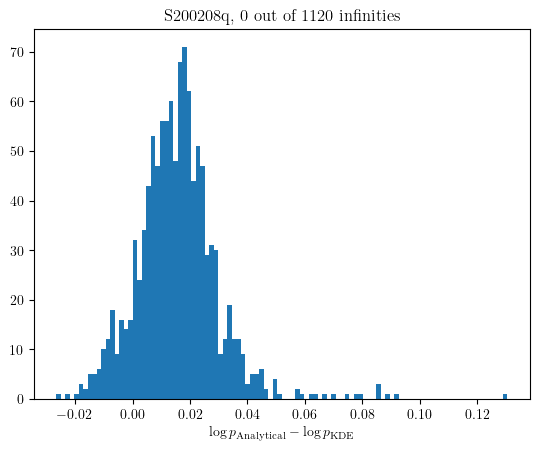

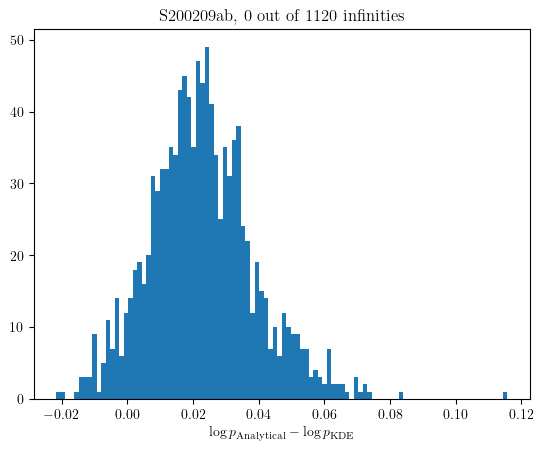

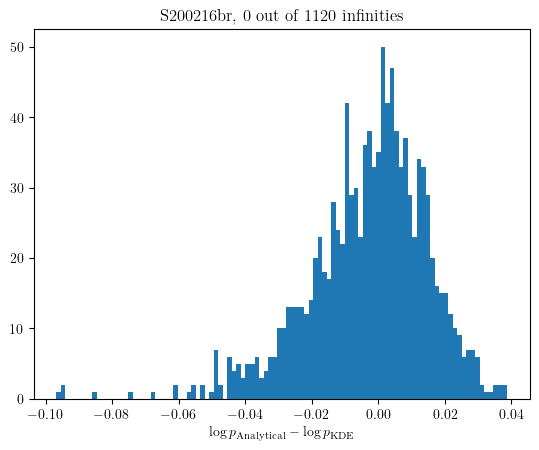

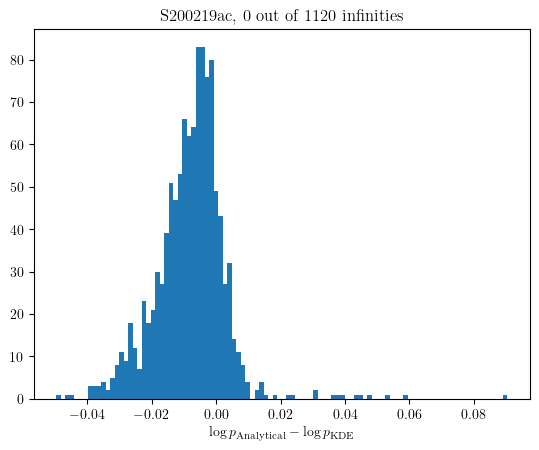

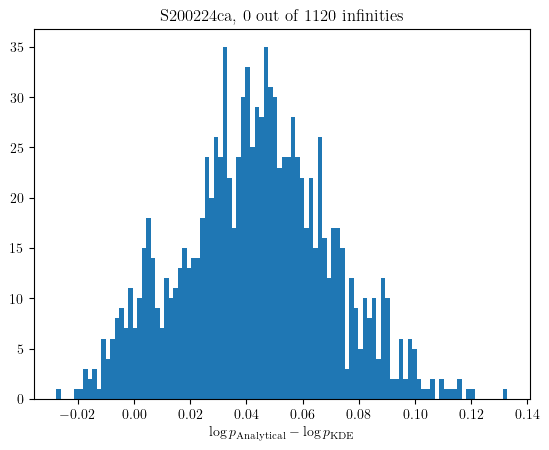

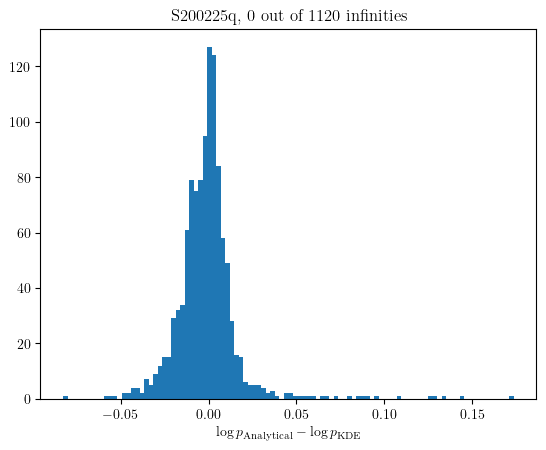

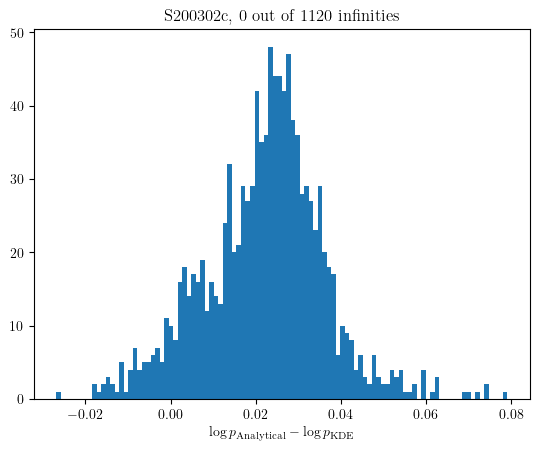

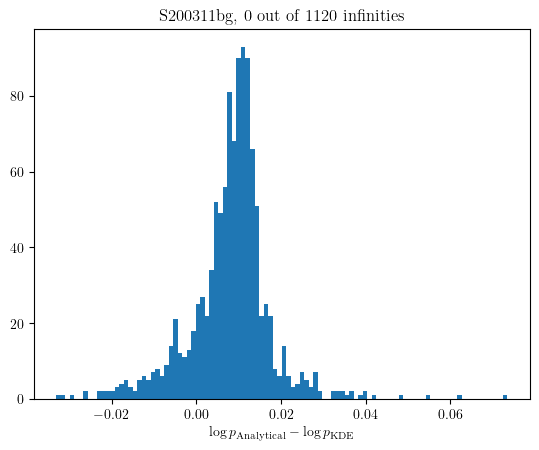

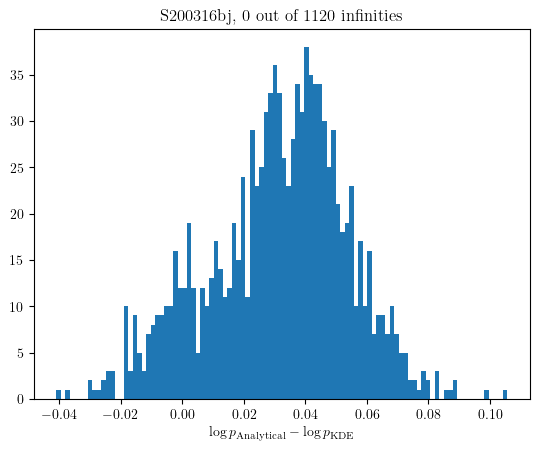

In [34]:
logps_diff = dict((k,logps_A_components[k] - logps_K_components[k]) for k in logps_K_components.keys())
bad_keys = []

for k in tqdm(logps_diff.keys()):
    idxs = logps_diff[k] < np.inf
    N = len(idxs) - np.sum(idxs)
    if N > 0:
        bad_keys.append(k)
        continue
    #if N == 0:
    #    continue

    plt.figure()
    plt.hist(logps_diff[k][idxs], bins=100)
    plt.xlabel(r"$\log p_{\mathrm{Analytical}} - \log p_{\mathrm{KDE}}$")
    plt.title(f"{k}, {N} out of {len(idxs)} infinities")
    plt.show()

In [35]:
bad_keys

[]

In [36]:
len(logps_diff['log_prior'])

1120

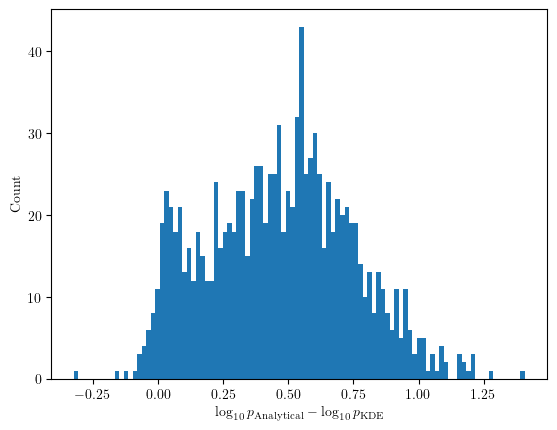

0.46341089228581733

In [37]:
overall_weight = []
for i in range(len(logps_diff['log_prior'])):
    ans = 0
    for k in logps_diff.keys():
        ans += np.log10(np.exp(logps_diff[k][i]))
    overall_weight.append(ans)
overall_weight = np.array(overall_weight)
plt.figure()
plt.hist(overall_weight[overall_weight > -np.inf], bins=100)
plt.xlabel(r"$\log_{10} p_{\mathrm{Analytical}} - \log_{10} p_{\mathrm{KDE}}$")
plt.ylabel('Count')
#    plt.title(f"{k}, {N} out of {len(idxs)} infinities")
plt.show()
np.mean(overall_weight)

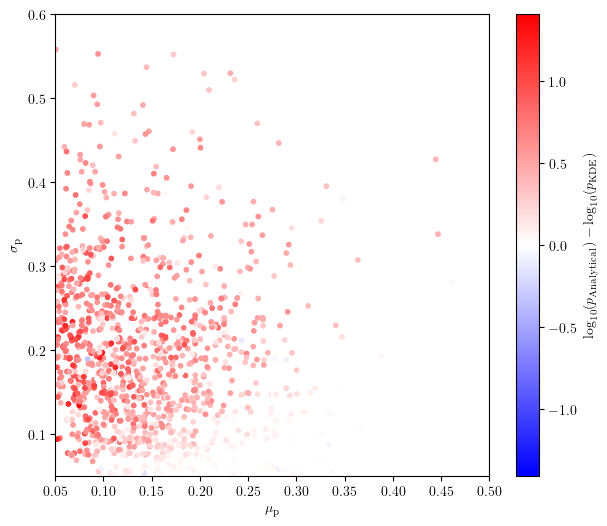

In [38]:
import matplotlib.cm as cm
plt.figure(figsize=(7,6))
sc = plt.scatter(samples['mu_p'][:],samples['sigma_p'][:],
            vmin=-np.max(overall_weight),vmax=np.max(overall_weight),c =overall_weight[:],cmap=cm.bwr, s=10)
plt.colorbar(sc,label=r'$\log_{10}(p_\mathrm{Analytical})-\log_{10}(p_\mathrm{KDE})$')
plt.xlim(0.05,0.5)
plt.ylim(0.05,0.6)
plt.xlabel(r'$\mu_\mathrm{p}$')
plt.ylabel(r'$\sigma_\mathrm{p}$')
plt.show()

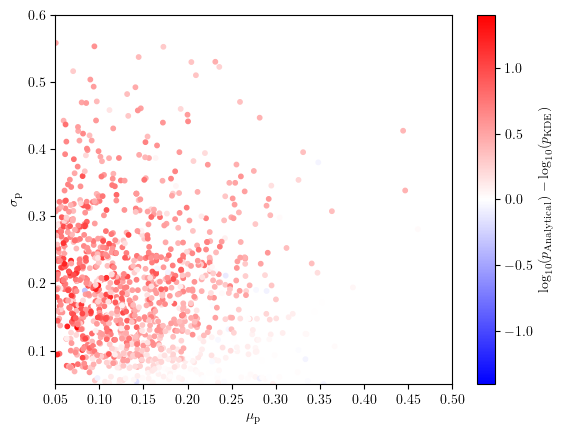

(array([138., 157., 148., 132., 140., 107.,  89.,  64.,  45.,  38.,  30.,
          9.,   9.,   7.,   1.,   1.,   0.,   2.,   2.,   0.]),
 array([0.05  , 0.0725, 0.095 , 0.1175, 0.14  , 0.1625, 0.185 , 0.2075,
        0.23  , 0.2525, 0.275 , 0.2975, 0.32  , 0.3425, 0.365 , 0.3875,
        0.41  , 0.4325, 0.455 , 0.4775, 0.5   ]),
 <BarContainer object of 20 artists>)

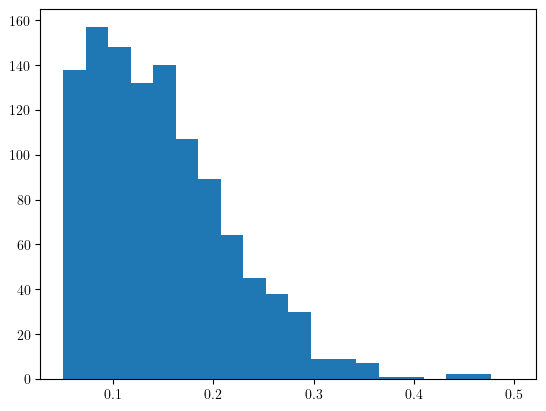

In [39]:
import matplotlib.cm as cm
sc = plt.scatter(samples['mu_p'][:],samples['sigma_p'][:],
            vmin=-np.max(overall_weight),vmax=np.max(overall_weight),c =overall_weight[:],cmap=cm.bwr, s=10)
plt.colorbar(sc,label=r'$\log_{10}(p_\mathrm{Analytical})-\log_{10}(p_\mathrm{KDE})$')
plt.xlim(0.05,0.5)
plt.ylim(0.05,0.6)
plt.xlabel(r'$\mu_\mathrm{p}$')
plt.ylabel(r'$\sigma_\mathrm{p}$')
plt.show()
plt.hist(samples['mu_p'],range=(0.05,0.5),bins=20)

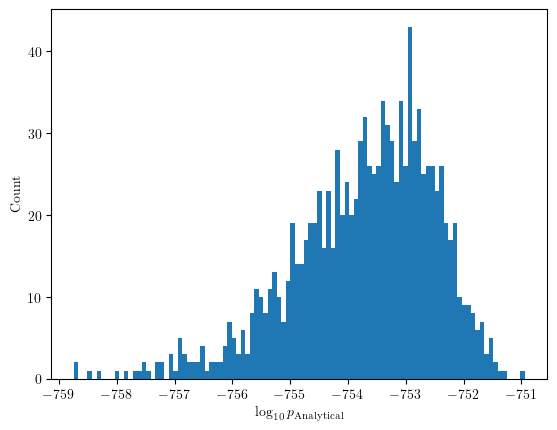

-753.7256787546565

In [40]:
A_weight = []
for i in range(len(logps_A_components['log_prior'])):
    ans = 0
    for k in logps_A_components.keys():
        ans += logps_A_components[k][i]*np.log10(np.exp(1))
    A_weight.append(ans)
A_weight = np.array(A_weight)
plt.figure()
plt.hist(A_weight[A_weight > -np.inf], bins=100)
plt.xlabel(r"$\log_{10} p_{\mathrm{Analytical}}$")
plt.ylabel('Count')
#    plt.title(f"{k}, {N} out of {len(idxs)} infinities")
plt.show()
np.mean(A_weight)
#logps_A_components

In [41]:
np.max(A_weight)

-750.941492178565

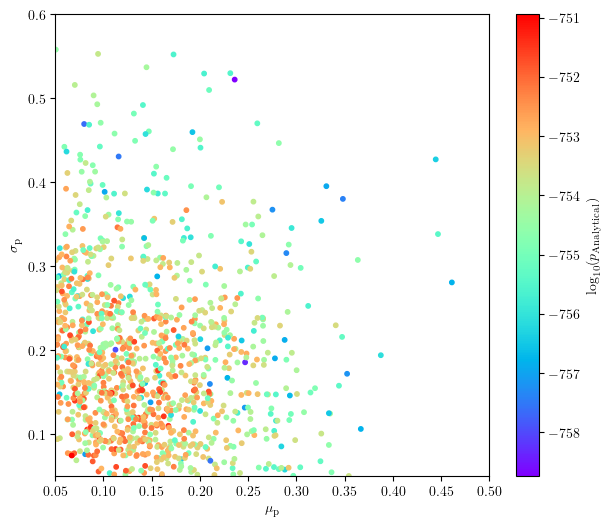

(array([138., 157., 148., 132., 140., 107.,  89.,  64.,  45.,  38.,  30.,
          9.,   9.,   7.,   1.,   1.,   0.,   2.,   2.,   0.]),
 array([0.05  , 0.0725, 0.095 , 0.1175, 0.14  , 0.1625, 0.185 , 0.2075,
        0.23  , 0.2525, 0.275 , 0.2975, 0.32  , 0.3425, 0.365 , 0.3875,
        0.41  , 0.4325, 0.455 , 0.4775, 0.5   ]),
 <BarContainer object of 20 artists>)

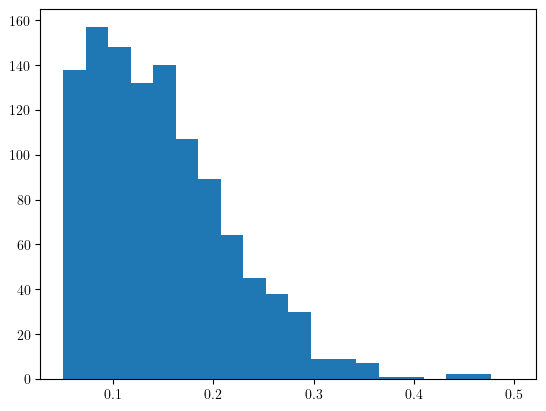

In [42]:
import matplotlib.cm as cm
plt.figure(figsize=(7,6))
sc = plt.scatter(samples['mu_p'][:],samples['sigma_p'][:],
            vmin=np.min(A_weight),vmax=np.max(A_weight),c = A_weight[:],cmap=cm.rainbow, s=10)
plt.colorbar(sc,label=r'$\log_{10}(p_\mathrm{Analytical})$')
plt.xlim(0.05,0.5)
plt.ylim(0.05,0.6)
plt.xlabel(r'$\mu_\mathrm{p}$')
plt.ylabel(r'$\sigma_\mathrm{p}$')
plt.show()
plt.hist(samples['mu_p'],range=(0.05,0.5),bins=20)

In [43]:
p0 = {}
for k in samples.keys():
    p0[k] = samples[k][np.argmin(samples['mu_p'])]
p0

{'lmbda': -3.0324800237568965,
 'mMax': 98.9864858302373,
 'm0': 35.68827671618892,
 'sigM': 1.8262165356107964,
 'fPeak': 0.07653679086875476,
 'bq': 0.6148179469169383,
 'kappa': 2.5247895804789495,
 'mu_eff': 0.027172327976726918,
 'sigma_eff': 0.11485882318191538,
 'mu_p': 0.05057263936212678,
 'sigma_p': 0.3070319303731177,
 'rho': 0.2673885573311984}

In [44]:
samples.keys()

dict_keys(['lmbda', 'mMax', 'm0', 'sigM', 'fPeak', 'bq', 'kappa', 'mu_eff', 'sigma_eff', 'mu_p', 'sigma_p', 'rho'])

In [45]:
ans_K = 0
for k in logps_K_components.keys():
    ans_K += logps_K_components[k][110]
ans_K

-1735.6156786042923

In [46]:
ans_A = 0
for k in logps_K_components.keys():
    ans_A += logps_A_components[k][110]
ans_A

-1734.257953356104

In [47]:
ans = 0
for k in logps_diff.keys():
    ans += logps_diff[k][1]
ans

1.352145197663603

In [48]:
samples['mu_p'][0],samples['sigma_p'][0]

(0.10528430568370101, 0.3613238315768762)

In [49]:
from gaussianLikelihoods import *
samples_K = {
    "lmbda": processed_samps_K[:, 0],
    "mMax": processed_samps_K[:, 1],
    "m0": processed_samps_K[:, 2],
    "sigM": processed_samps_K[:, 3],
    "fPeak": processed_samps_K[:, 4],
    "bq": processed_samps_K[:, 5],
    "kappa": processed_samps_K[:, 6],
    "mu_eff": processed_samps_K[:, 7],
    "sigma_eff": processed_samps_K[:, 8],
    "mu_p": processed_samps_K[:, 9],
    "sigma_p": processed_samps_K[:, 10],
    "rho": processed_samps_K[:, 11],
}
N_samps = len(samples_K["lmbda"])
param_names = ["lmbda", "mMax", "m0", "sigM", "fPeak", "bq", "kappa", "mu_eff", "sigma_eff", "mu_p", "sigma_p", "rho"]
samples_K_list = [[samples_K[k][i] for k in param_names] for i in range(N_samps)]
logps_K_components_K = []
logps_A_components_K = []
for i in tqdm(list(range(N_samps))):
#    logps_KDE.append(log_posterior_KDE(samples_list[i]))
#    logps_Analytical.append(log_posterior_Analytical(samples_list[i]))
    logps_K_components_K.append(log_posterior_K_components(samples_K_list[i]))
    logps_A_components_K.append(log_posterior_A_components(samples_K_list[i]))

  0%|          | 0/1120 [00:00<?, ?it/s]

In [50]:
logps_K_components_K = dict((k, np.array([logps_K_components_K[i][k] for i in range(N_samps)])) for k in logps_K_components_K[0].keys())
logps_A_components_K = dict((k, np.array([logps_A_components_K[i][k] for i in range(N_samps)])) for k in logps_A_components_K[0].keys())

  0%|          | 0/71 [00:00<?, ?it/s]

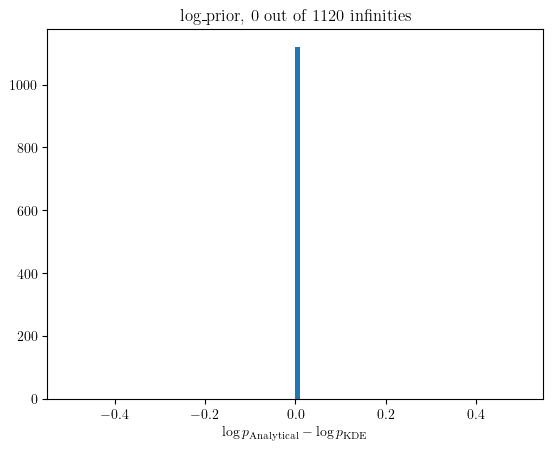

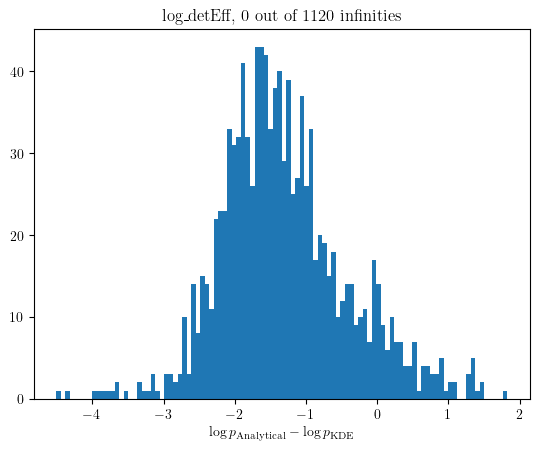

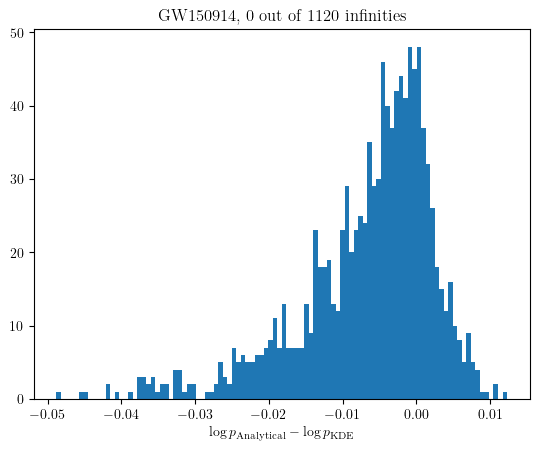

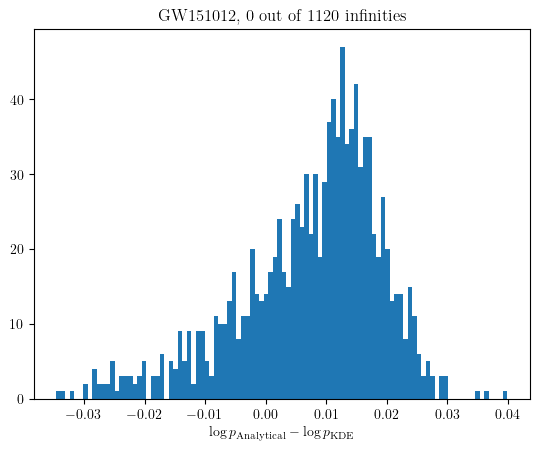

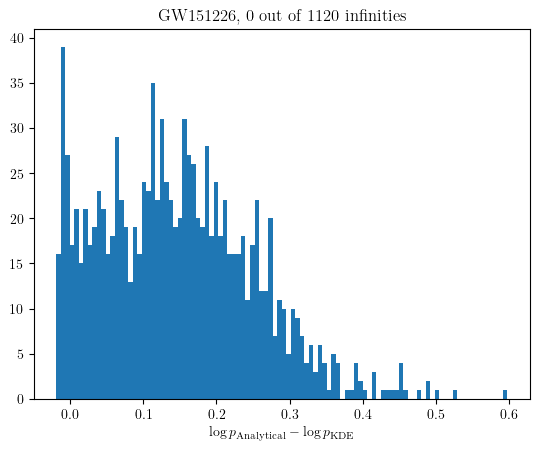

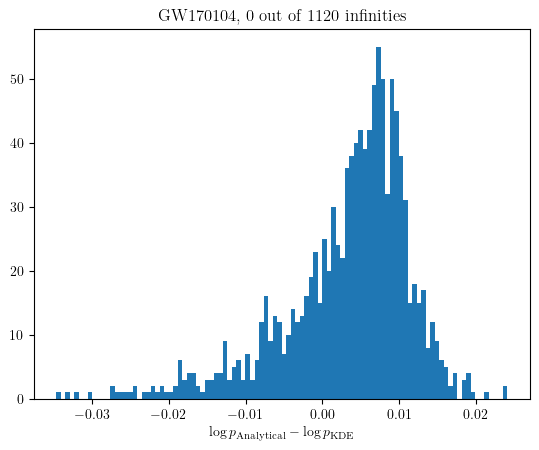

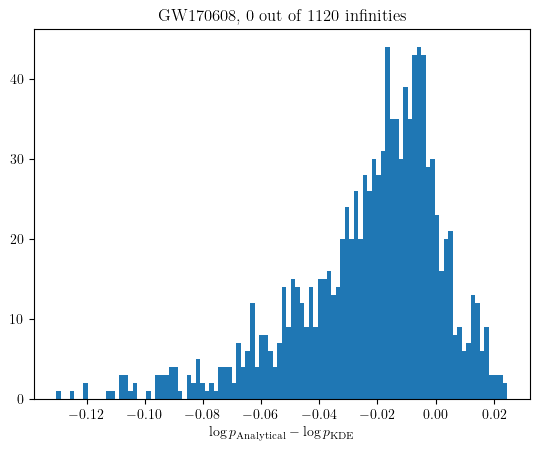

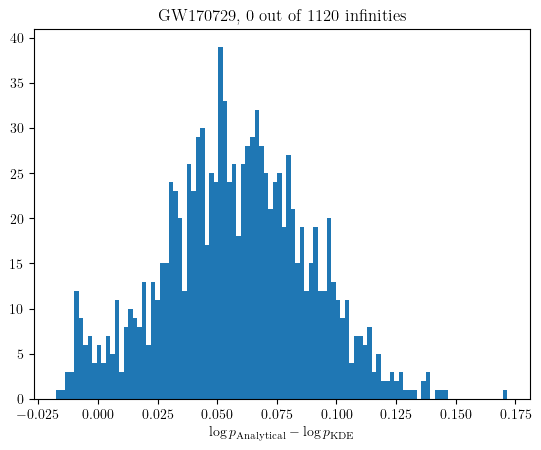

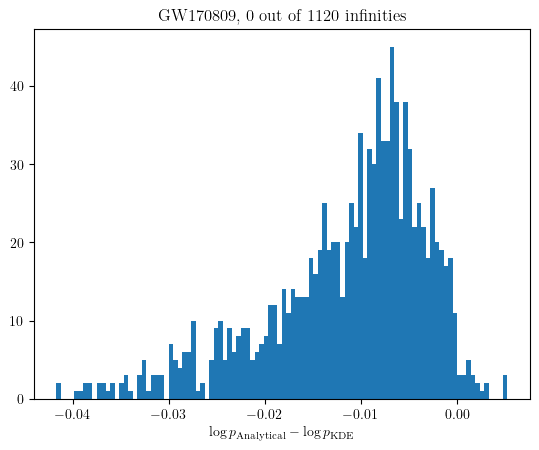

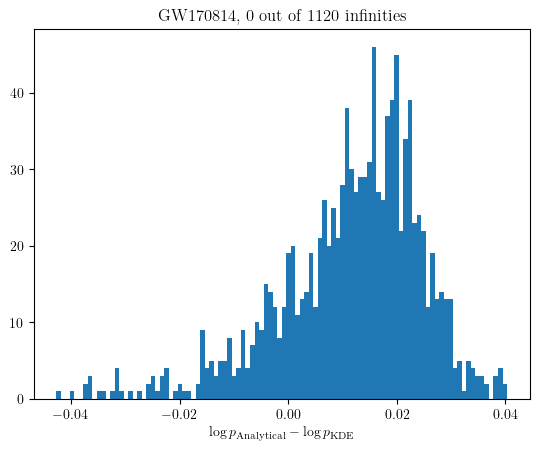

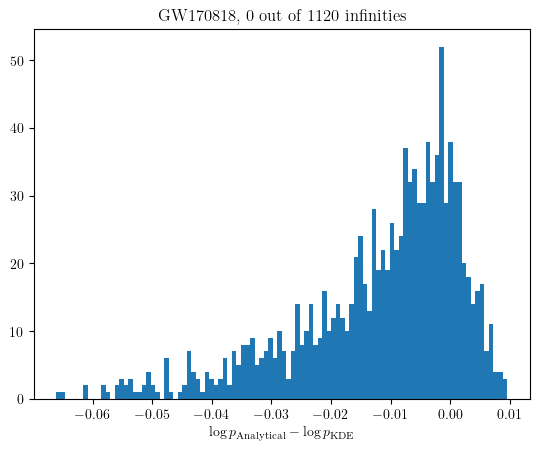

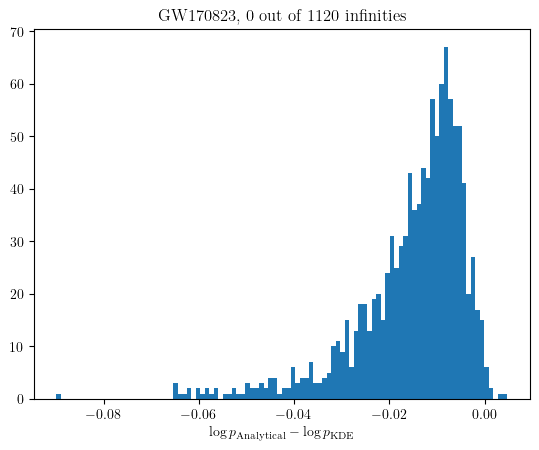

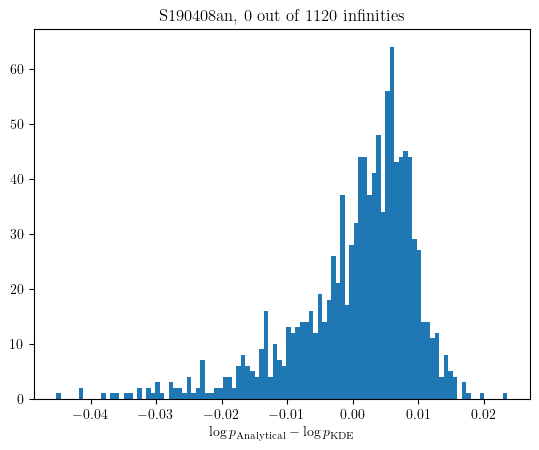

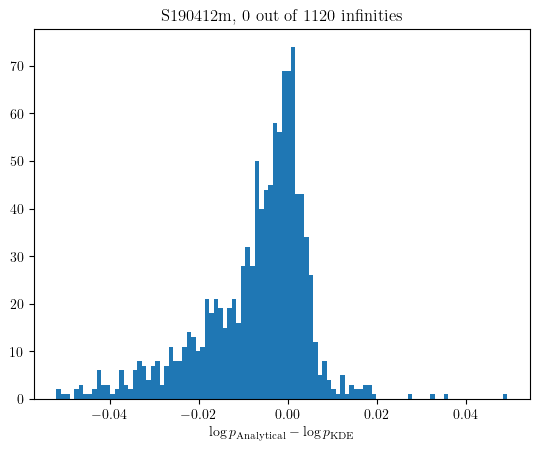

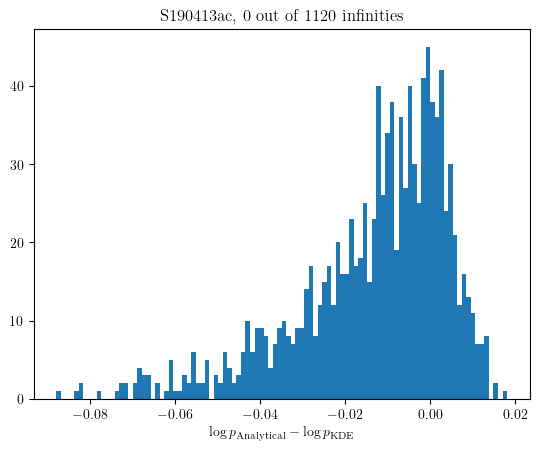

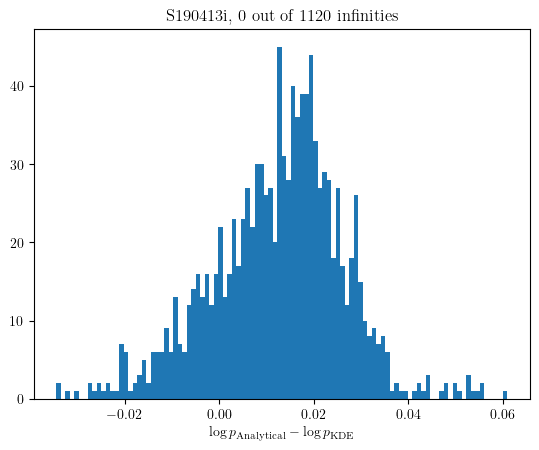

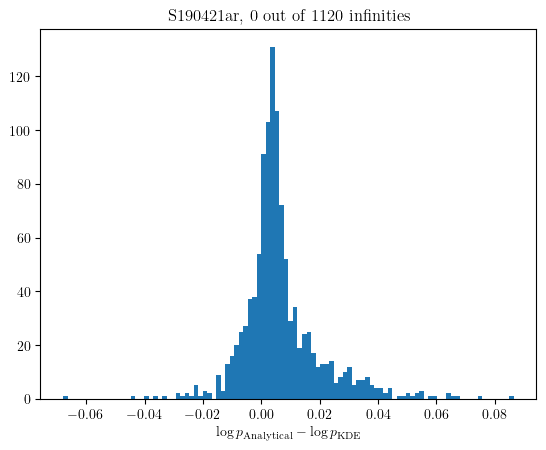

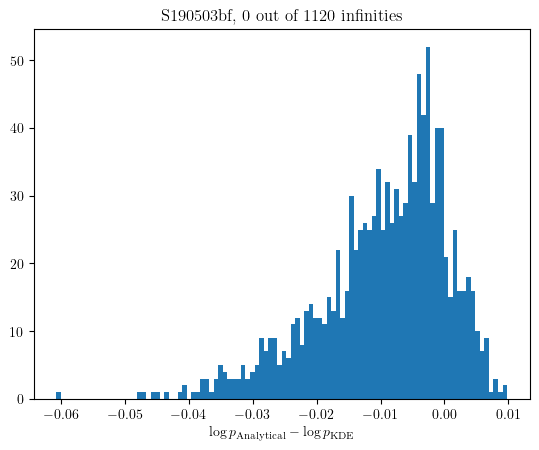

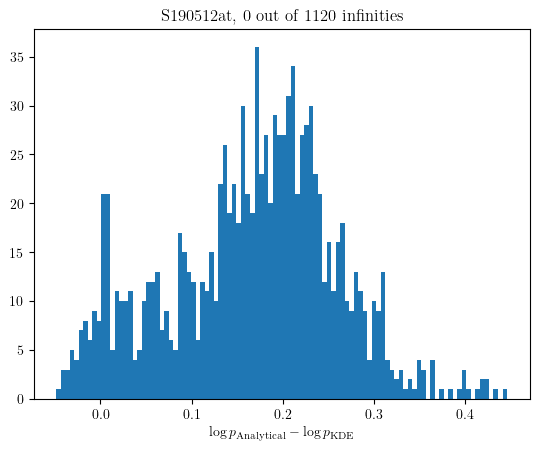

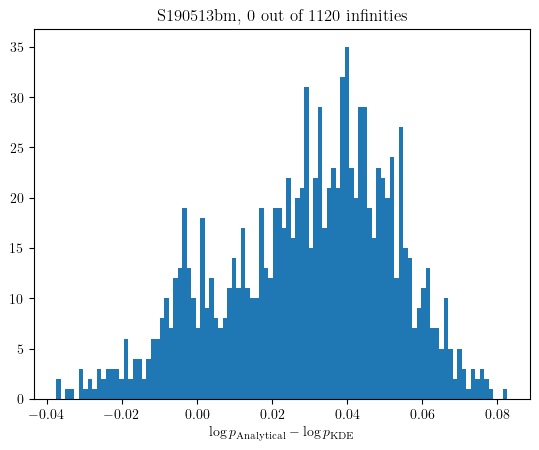

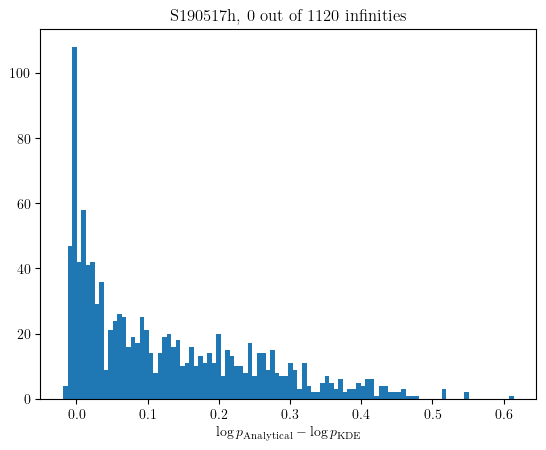

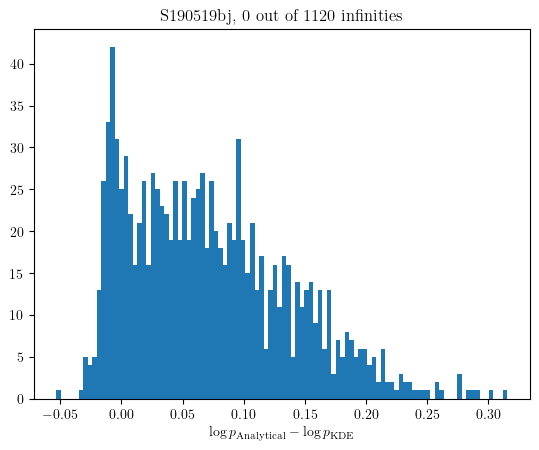

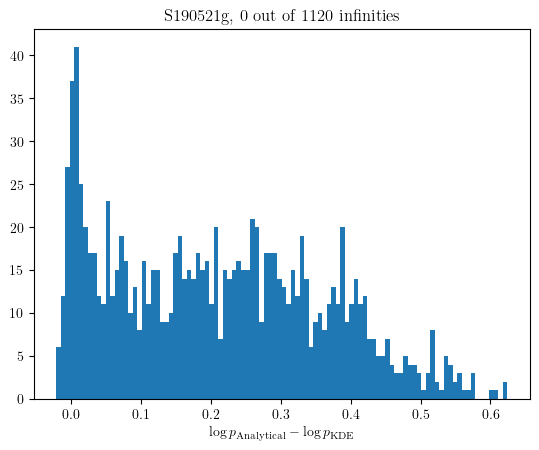

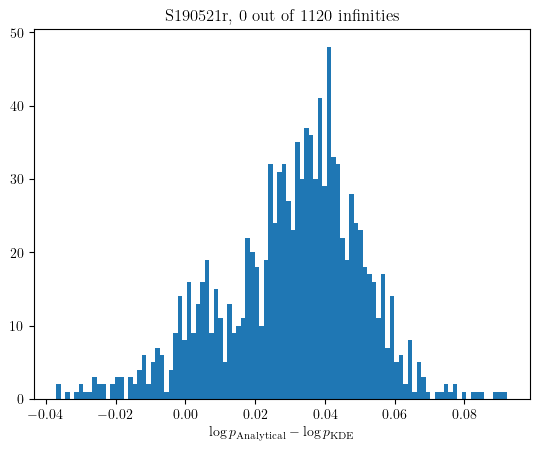

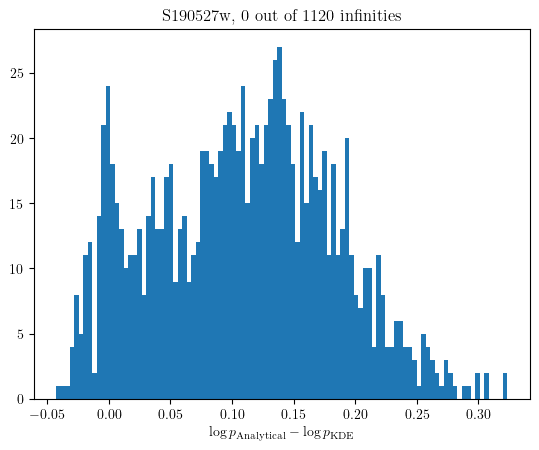

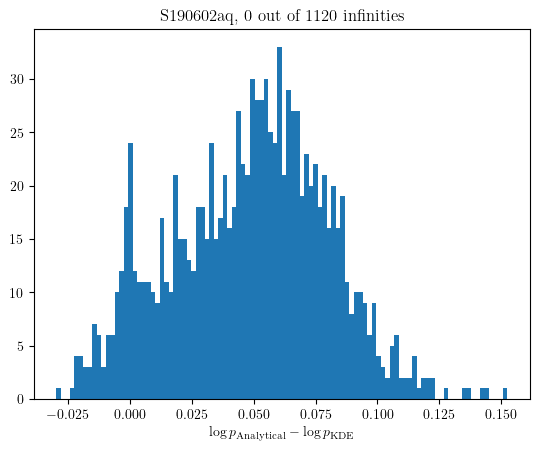

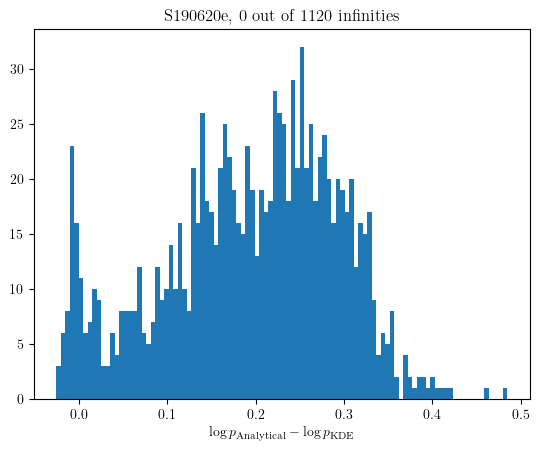

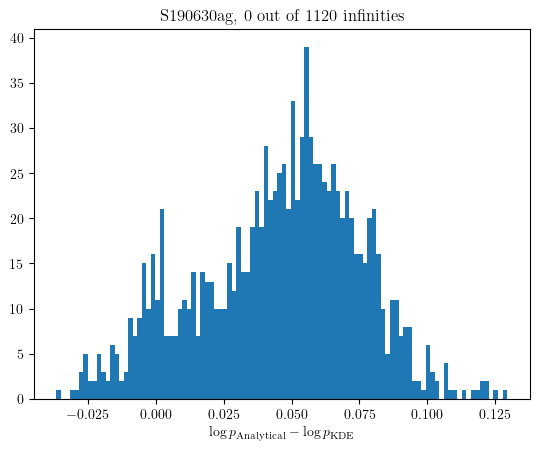

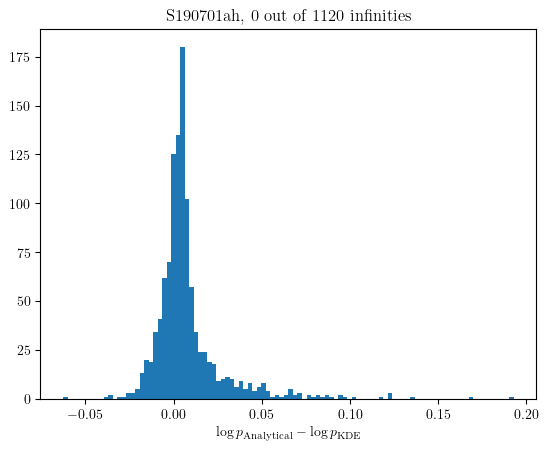

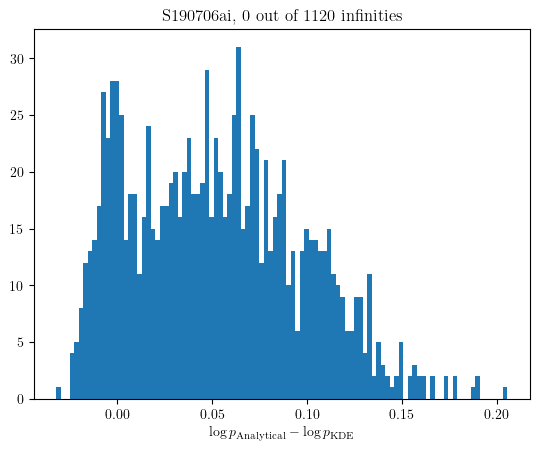

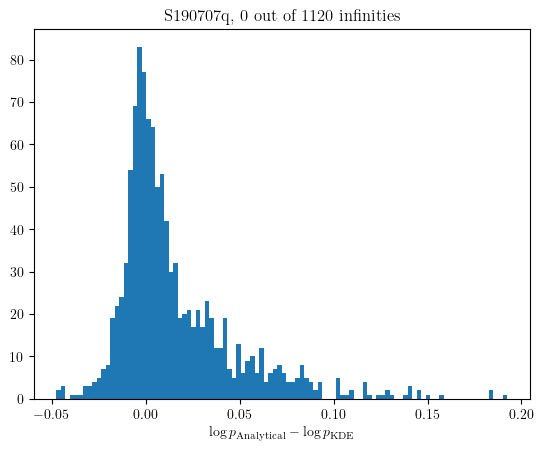

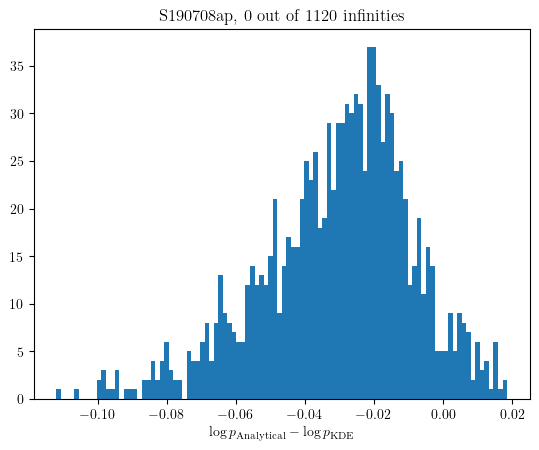

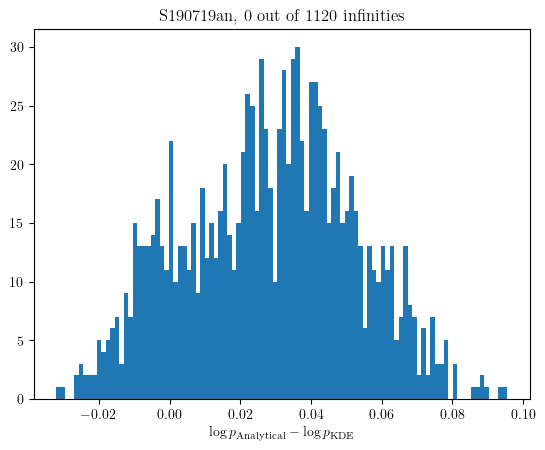

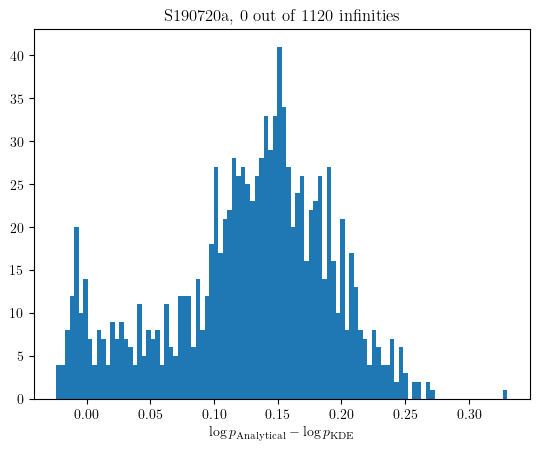

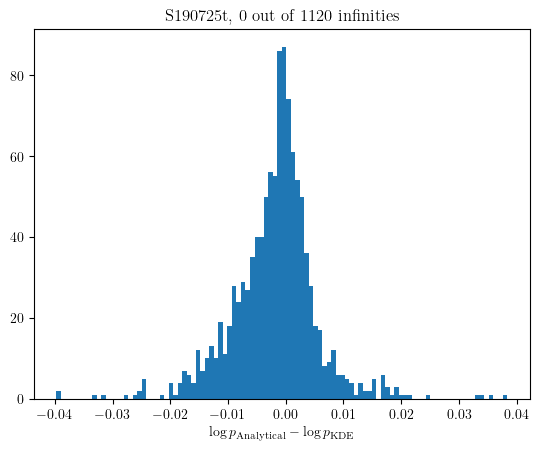

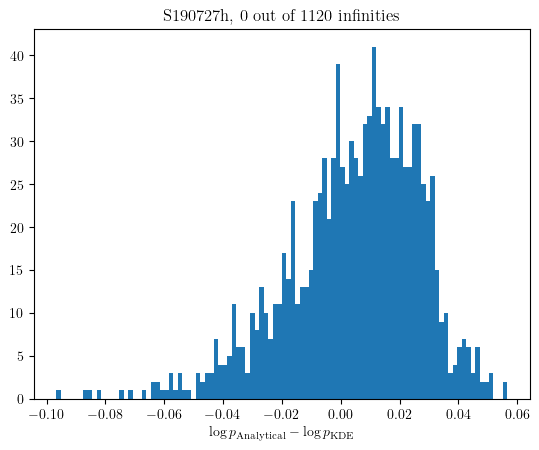

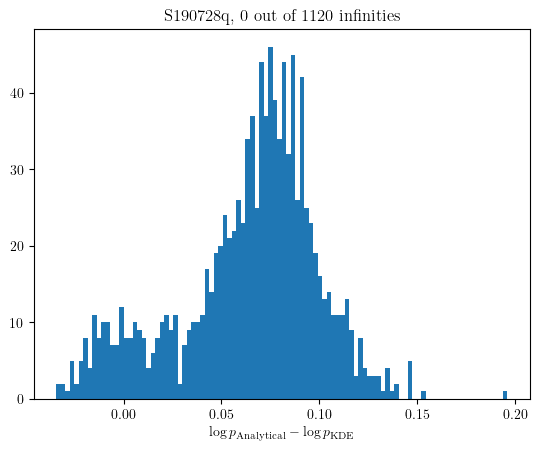

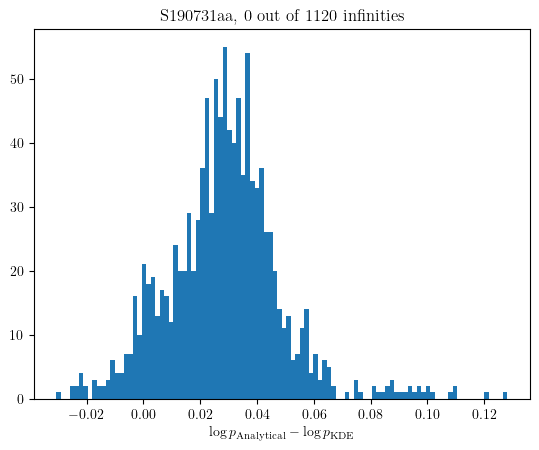

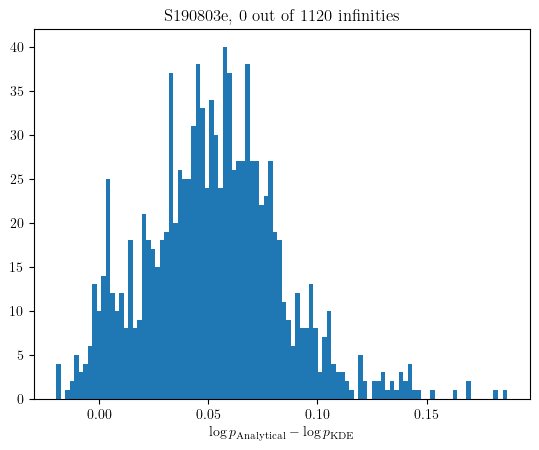

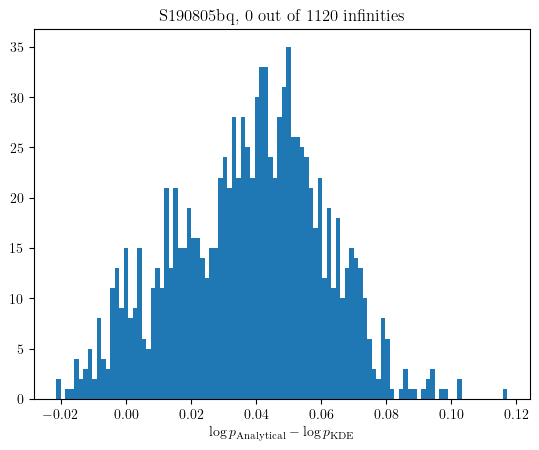

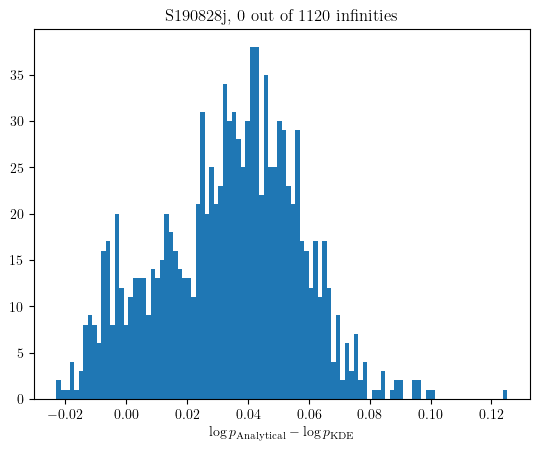

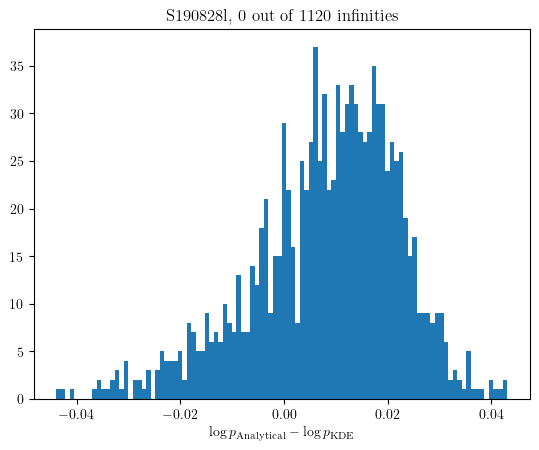

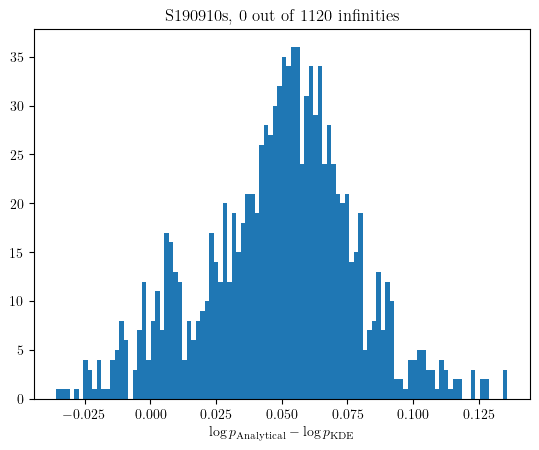

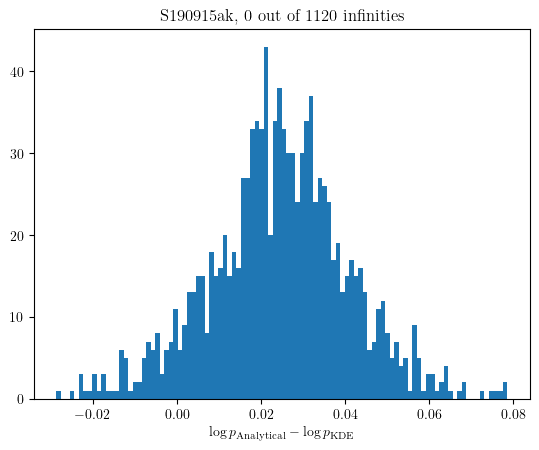

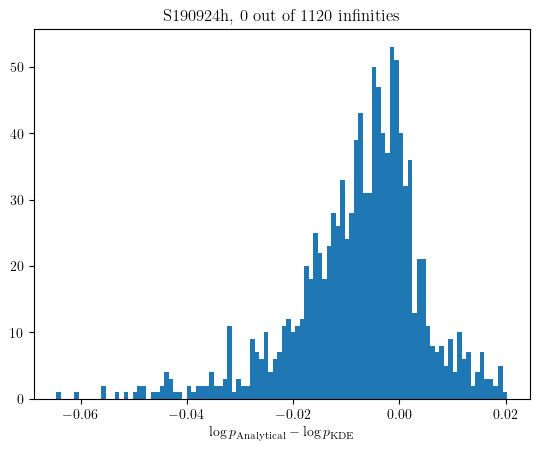

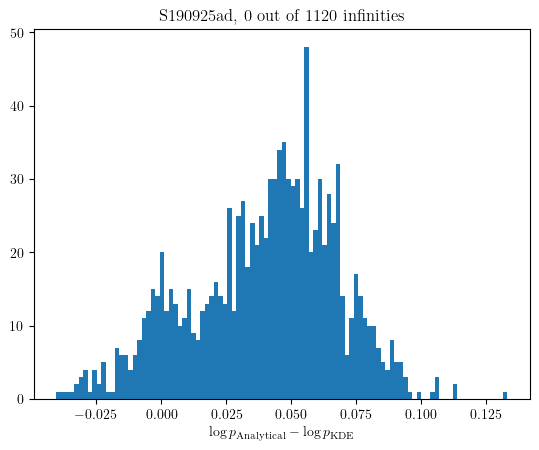

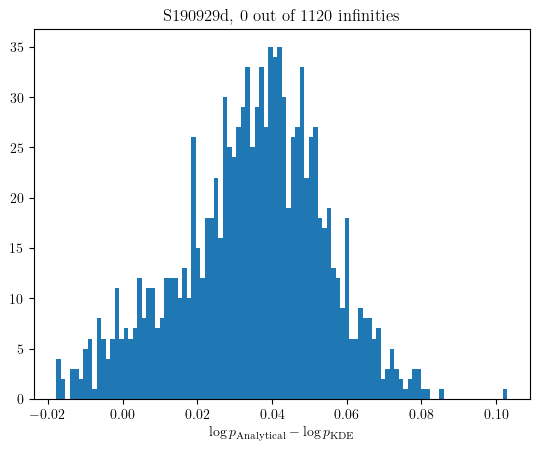

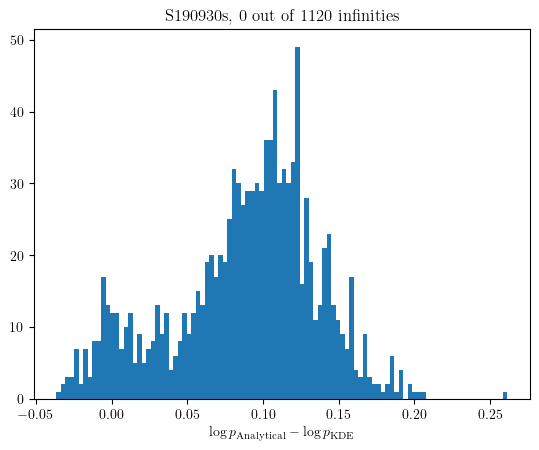

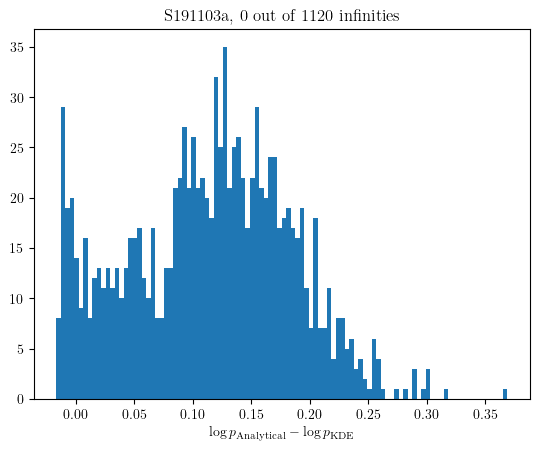

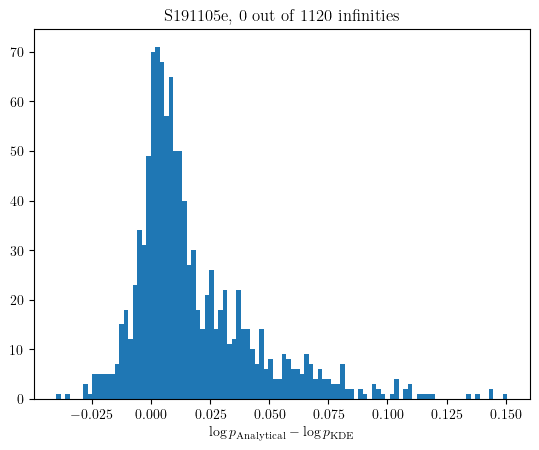

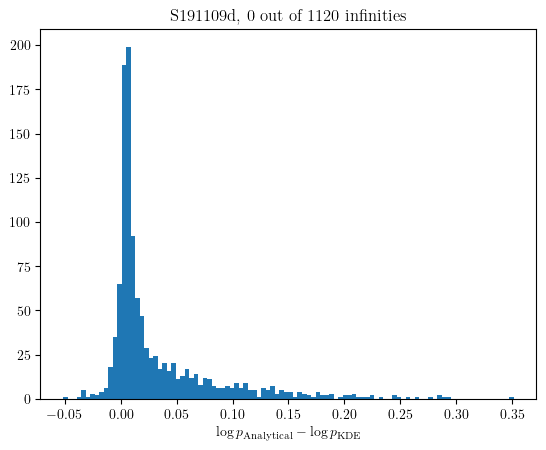

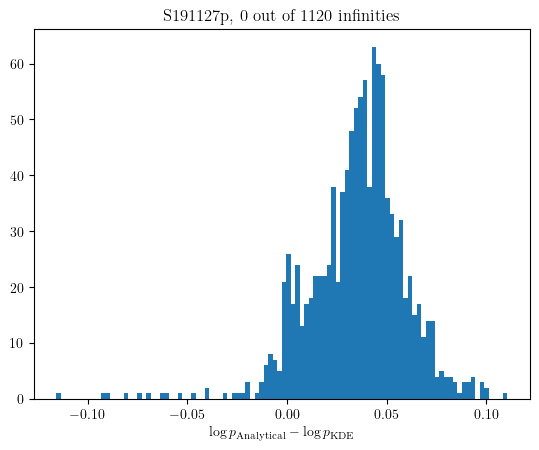

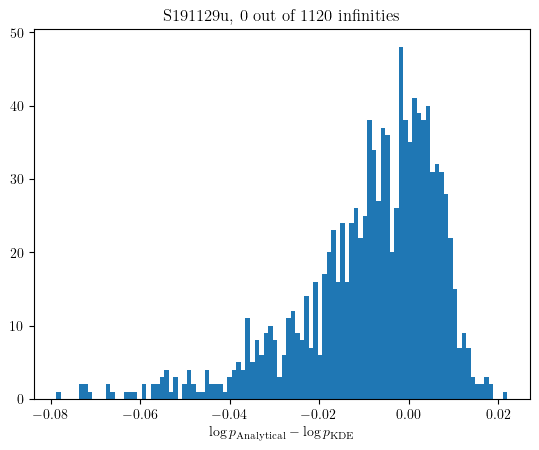

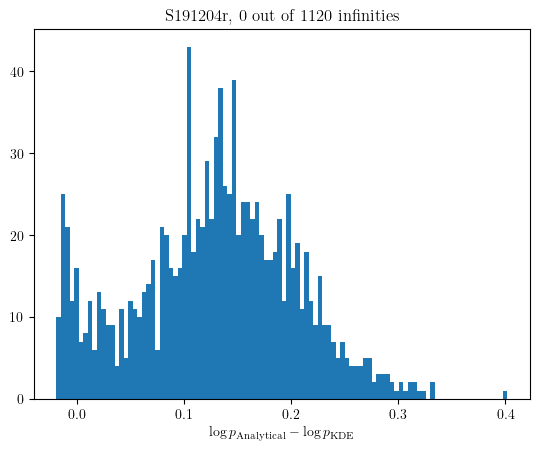

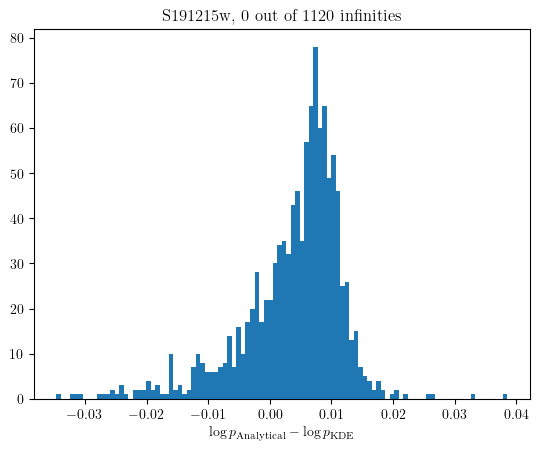

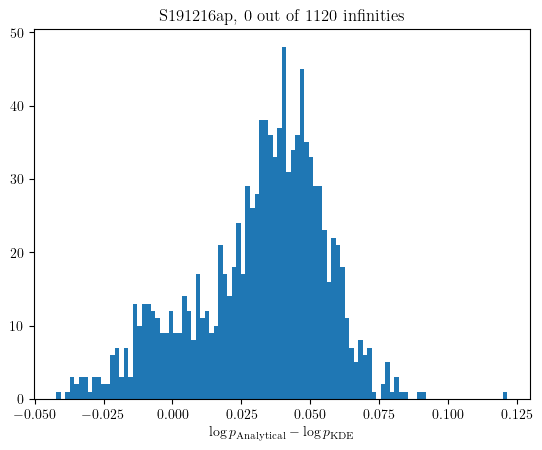

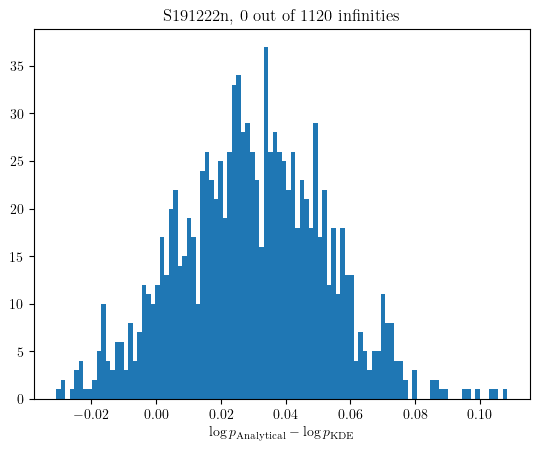

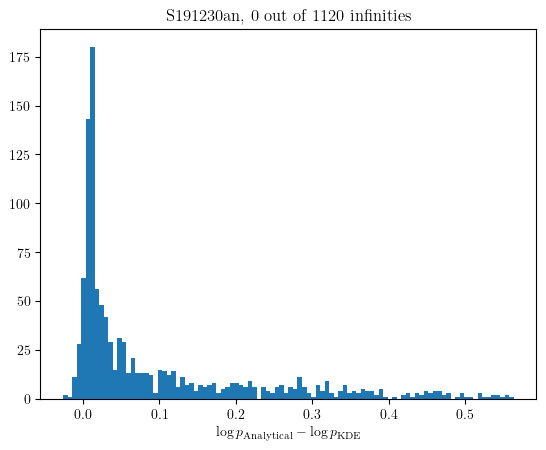

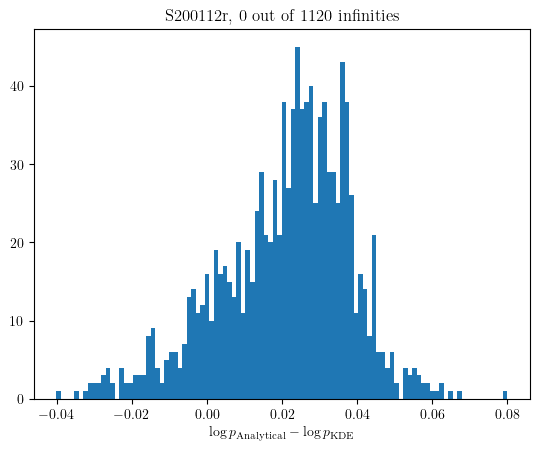

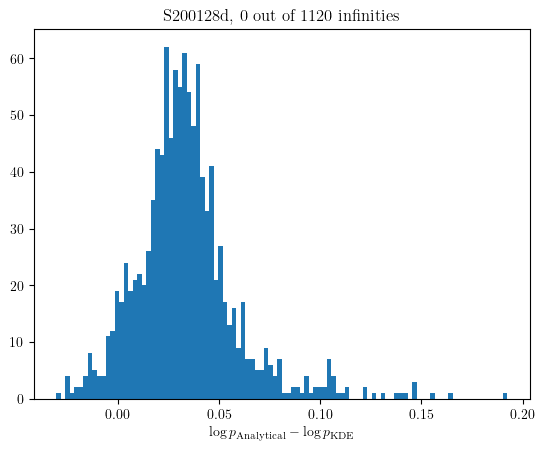

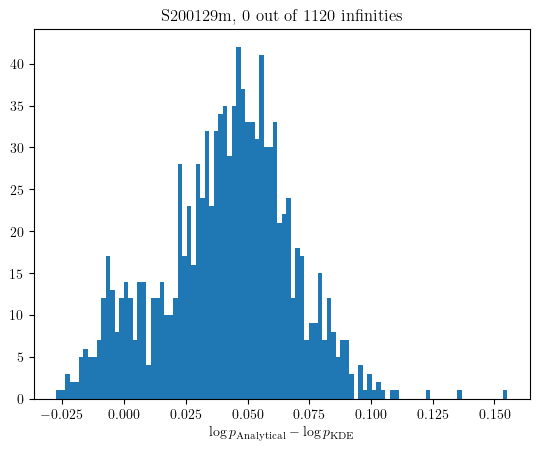

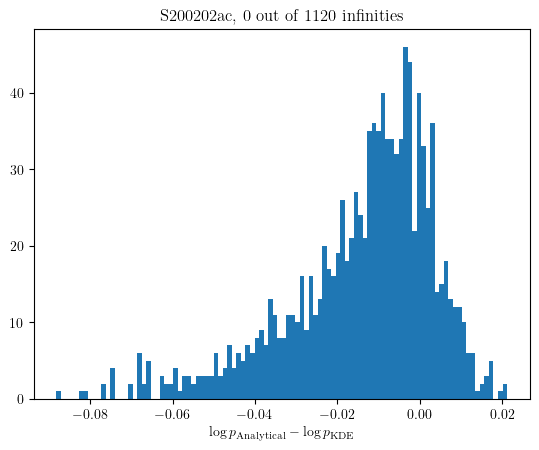

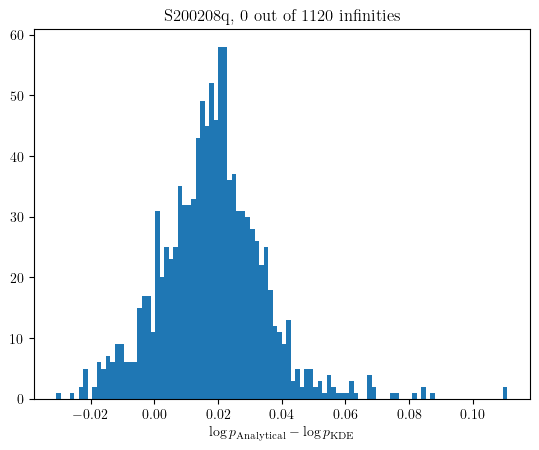

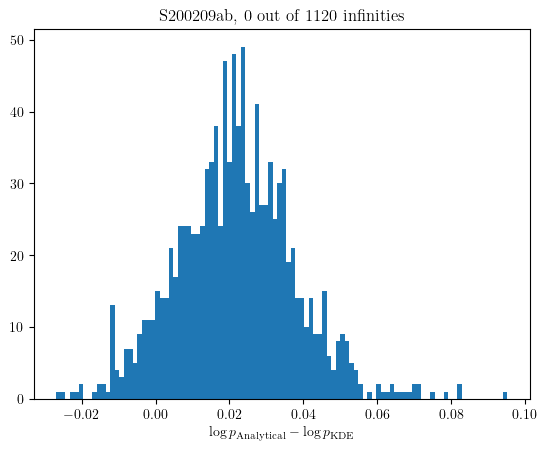

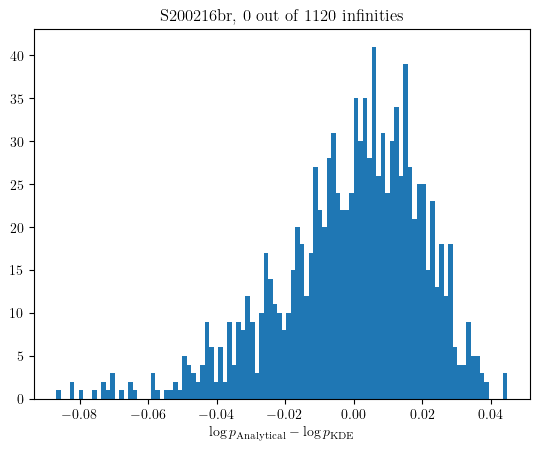

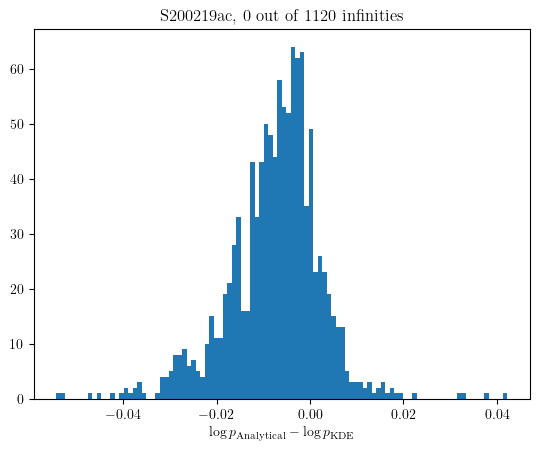

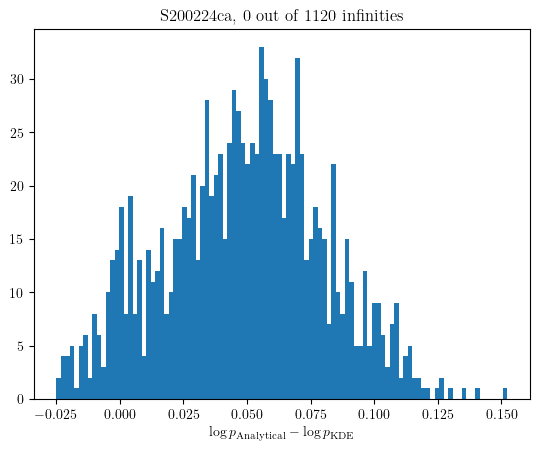

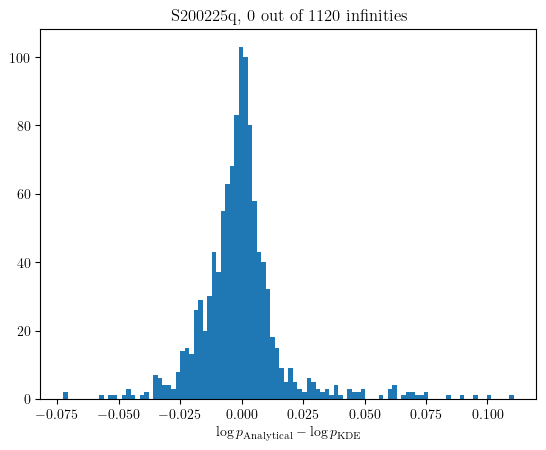

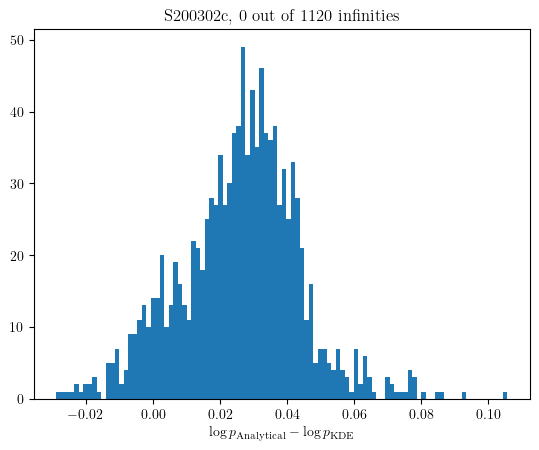

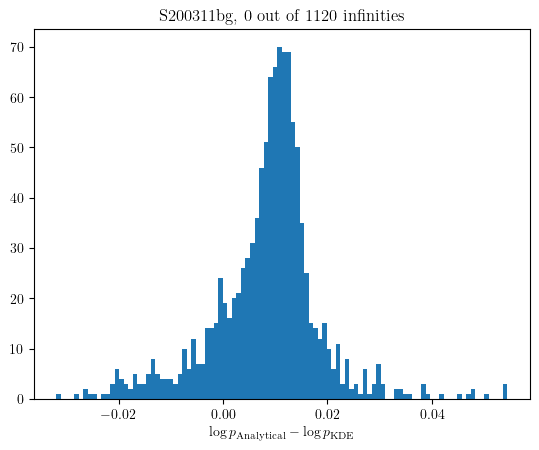

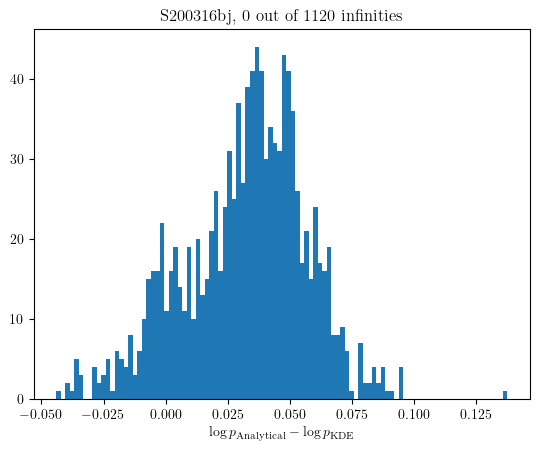

In [51]:
logps_diff_K = dict((k,logps_A_components_K[k] - logps_K_components_K[k]) for k in logps_K_components_K.keys())
bad_keys = []

for k in tqdm(logps_diff_K.keys()):
    idxs = logps_diff_K[k] > -np.inf
    N = len(idxs) - np.sum(idxs)
    if N > 0:
        bad_keys.append(k)
    #if N == 0:
    #    continue

    plt.figure()
    plt.hist(logps_diff_K[k][idxs], bins=100)
    plt.xlabel(r"$\log p_{\mathrm{Analytical}} - \log p_{\mathrm{KDE}}$")
    plt.title(f"{k}, {N} out of {len(idxs)} infinities")
    plt.show()

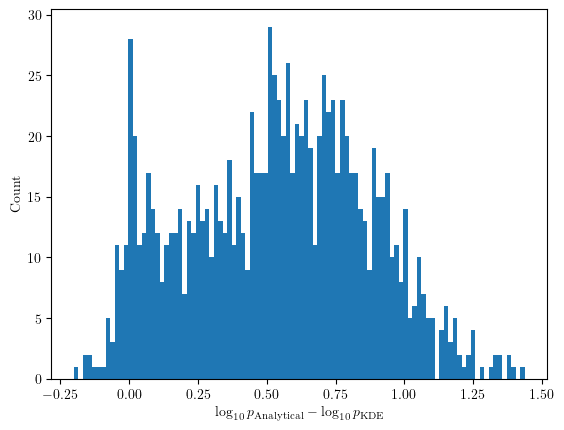

0.5368530000109781

In [52]:
overall_weight_K = []
for i in range(len(logps_diff_K['log_prior'])):
    ans = 0
    for k in logps_diff_K.keys():
        ans += np.log10(np.exp(logps_diff_K[k][i]))
    overall_weight_K.append(ans)
overall_weight_K = np.array(overall_weight_K)
plt.figure()
plt.hist(overall_weight_K[overall_weight_K > -np.inf], bins=100)
plt.xlabel(r"$\log_{10} p_{\mathrm{Analytical}} - \log_{10} p_{\mathrm{KDE}}$")
plt.ylabel('Count')
#    plt.title(f"{k}, {N} out of {len(idxs)} infinities")
plt.show()
np.mean(overall_weight_K[overall_weight_K > -np.inf])

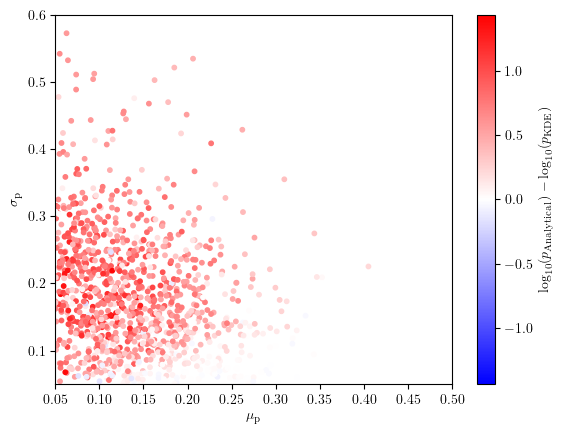

(array([136., 154., 171., 149., 131., 116.,  94.,  61.,  37.,  35.,  14.,
         11.,   4.,   4.,   0.,   1.,   1.,   0.,   0.,   0.]),
 array([0.05  , 0.0725, 0.095 , 0.1175, 0.14  , 0.1625, 0.185 , 0.2075,
        0.23  , 0.2525, 0.275 , 0.2975, 0.32  , 0.3425, 0.365 , 0.3875,
        0.41  , 0.4325, 0.455 , 0.4775, 0.5   ]),
 <BarContainer object of 20 artists>)

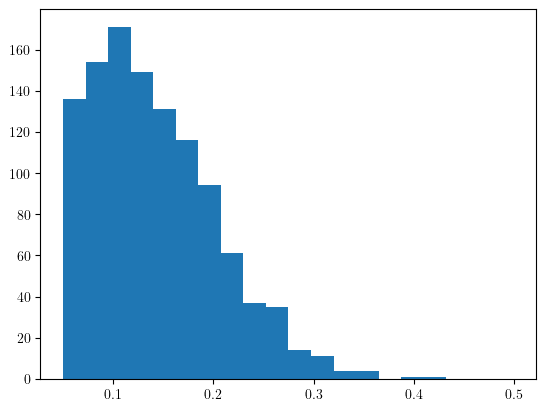

In [53]:
import matplotlib.cm as cm
sc = plt.scatter(samples_K['mu_p'][:],samples_K['sigma_p'][:],
            vmin=-np.max(overall_weight_K),vmax=np.max(overall_weight_K),c =overall_weight_K[:],cmap=cm.bwr, s=10)
plt.colorbar(sc,label=r'$\log_{10}(p_\mathrm{Analytical})-\log_{10}(p_\mathrm{KDE})$')
plt.xlim(0.05,0.5)
plt.ylim(0.05,0.6)
plt.xlabel(r'$\mu_\mathrm{p}$')
plt.ylabel(r'$\sigma_\mathrm{p}$')
plt.show()
plt.hist(samples_K['mu_p'],range=(0.05,0.5),bins=20)

In [54]:
logps_K_components_K[0]

KeyError: 0